# Air bnb price prediction - KNN

## Installing requirements

In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import load_model
import re 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import itertools
import time
from tqdm import tqdm
import csv

from sklearn.decomposition import PCA
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV


## Data preprocessing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/train_airbnb_berlin.csv', sep=',')
df[df == "*"] = np.nan

### Preliminary analysis

Let's analyze the proportion of missing values.

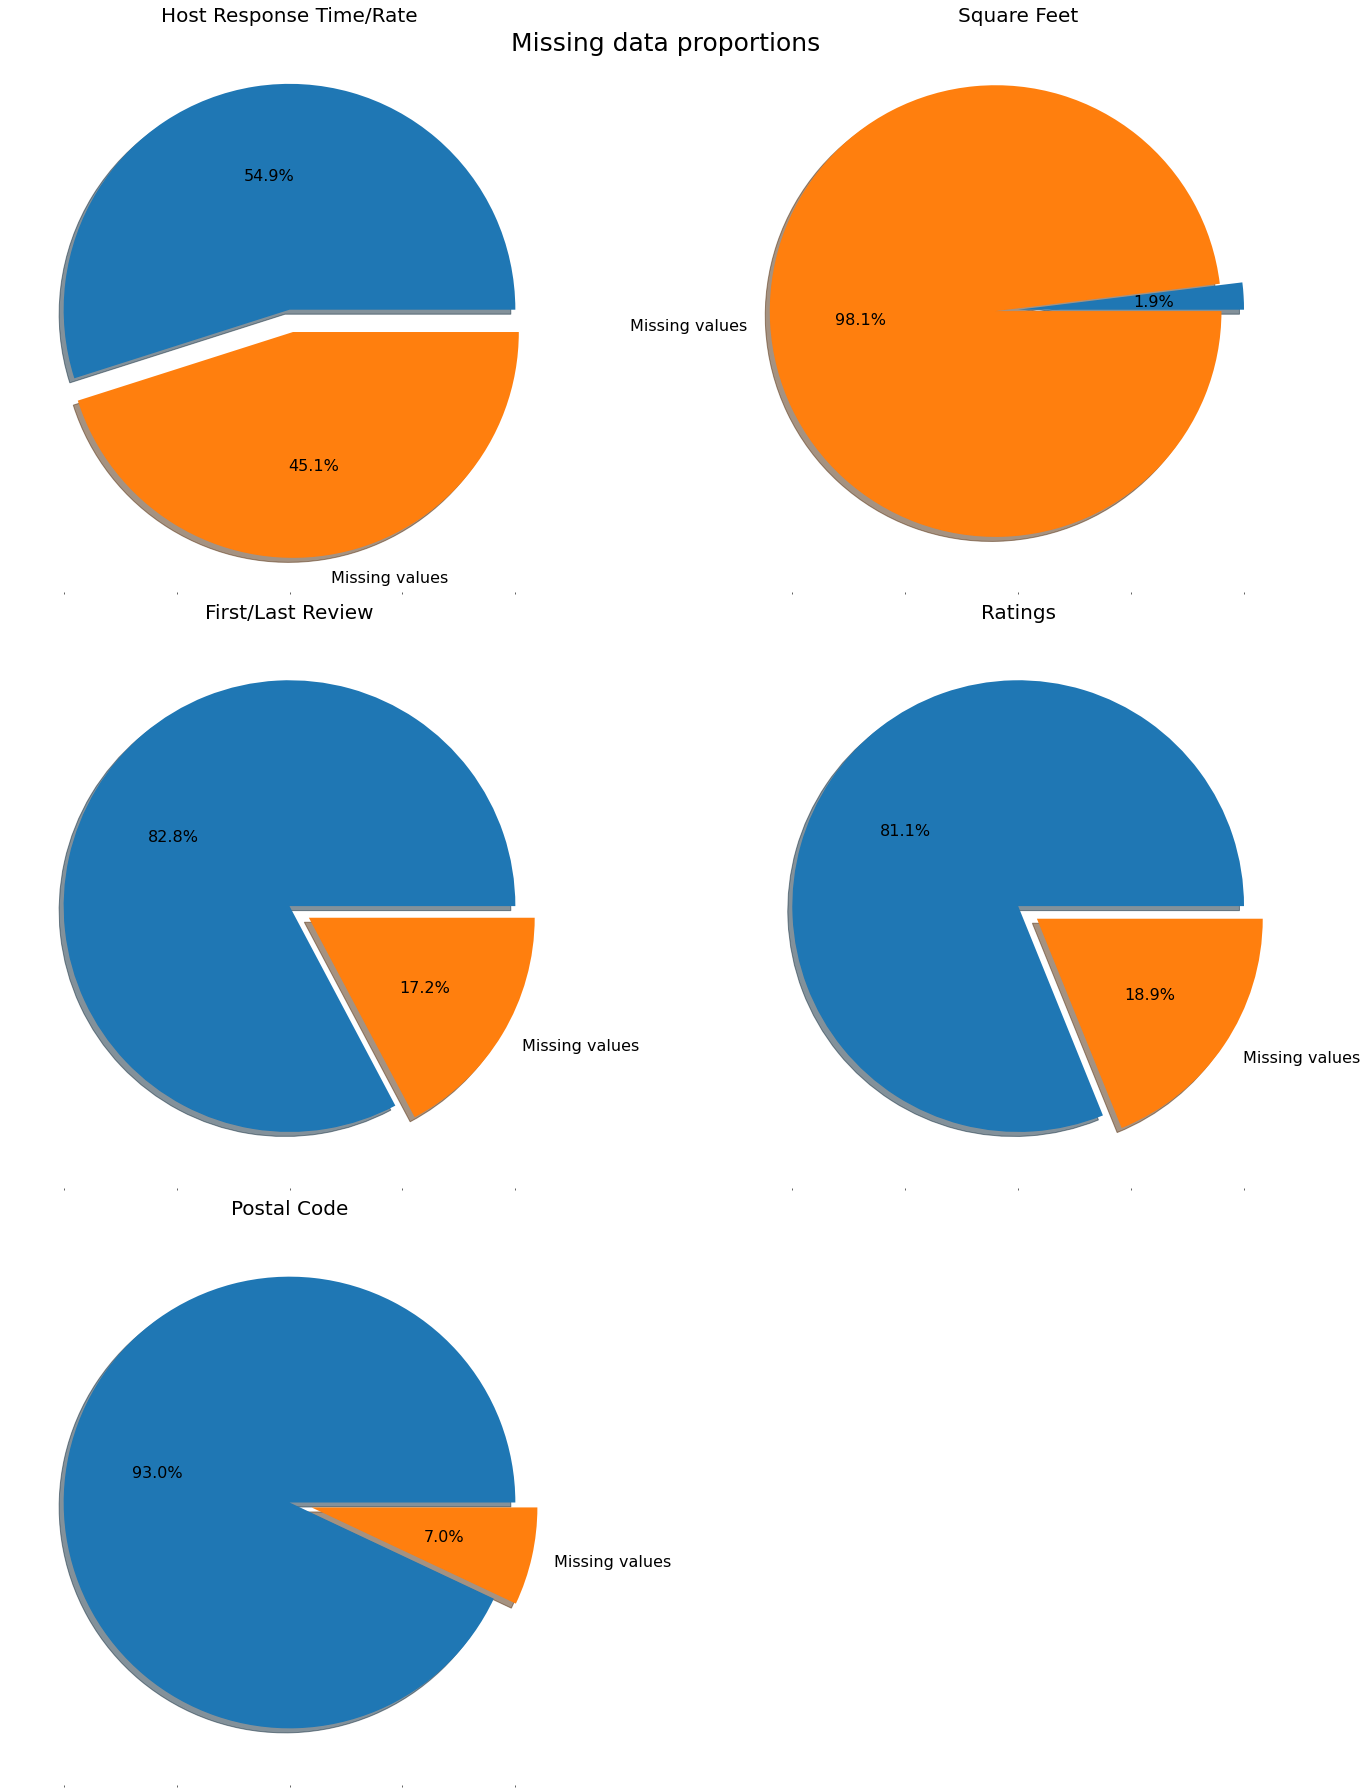

In [ ]:
import matplotlib.pyplot as plt

HRT = pd.Series({'':df["Host Response Time"].shape[0]-df["Host Response Time"].isna().sum(), 'Missing values': df["Host Response Time"].isna().sum()})
SQR_FT = pd.Series({'':df["Square Feet"].shape[0]-df["Square Feet"].isna().sum(), 'Missing values': df["Square Feet"].isna().sum()})
FL_RVW = pd.Series({'':df["First Review"].shape[0]-df["First Review"].isna().sum(), 'Missing values': df["First Review"].isna().sum()})
OVR_RATING = pd.Series({'':df["Overall Rating"].shape[0]-df["Overall Rating"].isna().sum(), 'Missing values': df["Overall Rating"].isna().sum()})
POSTAL = pd.Series({'':df["Postal Code"].shape[0]-df["Postal Code"].isna().sum(), 'Missing values': df["Postal Code"].isna().sum()})

df_subplot = pd.concat([HRT, SQR_FT, FL_RVW, OVR_RATING, POSTAL], axis=1, 
                       keys=['','','','','','']
                                                                          
                       )

#axes = df_subplot.plot(kind='pie', subplots=True, figsize=(20,20), \
#                      explode = (0, 0.1))

axes = df_subplot.plot(kind='pie', subplots=True, grid=True,
        layout=(3, 2), legend=False, explode = (0,0.1), shadow =True,
        figsize=(20,25), fontsize= 16, autopct='%1.1f%%', startangle=0
        )

axes[0][0].set_title('Host Response Time/Rate', fontsize=20)
axes[0][1].set_title('Square Feet', fontsize=20)
axes[1][0].set_title('First/Last Review', fontsize=20)
axes[1][1].set_title('Ratings', fontsize=20)
axes[2][0].set_title('Postal Code', fontsize=20)


plt.suptitle("Missing data proportions",  
             fontsize=25)
plt.tight_layout()
plt.show()

In [ ]:
df.isna().sum()

Listing ID                   1
Listing Name             15692
Host ID                      0
Host Name                   22
Host Since                  21
Host Response Time        7075
Host Response Rate        7249
Is Superhost                23
neighbourhood              203
Neighborhood Group           0
City                        48
Postal Code               1099
Country Code                 0
Country                      0
Latitude                     0
Longitude                    0
Is Exact Location            0
Property Type               75
Room Type                    0
Accomodates                 19
Bathrooms                   25
Bedrooms                    16
Beds                        20
Square Feet              15389
Guests Included             10
Min Nights                 249
Reviews                      0
First Review              2705
Last Review               2706
Overall Rating            2962
Accuracy Rating           2971
Cleanliness Rating        2970
Checkin 

### Preprocess function

In [ ]:
# Let's take out features that are deemed useless in the price prediction.

def preprocess_data_preliminary(df):
    df_clean = df.drop([#   "Host Name",   Keeping it for gender prediction in phase 2
                        "Host ID",
                        "Listing ID",
                        "Listing Name",
                        "neighbourhood",
                        #   "Neighborhood Group",    Keeping Neighborhood Group for phase 2
                        "City",
                        "Country Code",
                        "Country",
                        "Postal Code",
                        "Square Feet", 
                        "First Review",
                        "Last Review",
                        "Business Travel Ready"], axis=1)


    # Dropping NaNs where it doesn't pose a problem. Merely 3% of the entire dataset.

    df_clean = df_clean.dropna(subset=["Host Name", # Adding it for phase 2 (only 2 NaNs)
                                      "Host Since",
                                      "Is Superhost",
                                      "Property Type",
                                      "Accomodates",
                                      "Bathrooms",
                                      "Bedrooms",
                                      "Beds",
                                      "Guests Included",
                                      "Min Nights",
                                      "Price"])

    # Let's fill NaN values by "unknown" where we can.  

    df_clean.loc[df_clean['Host Response Time'].isna(), "Host Response Time"]='unknown'

    # Replacing binary values by 0 and 1

    df_clean.loc[df_clean["Is Superhost"]=='t', "Is Superhost"]=1
    df_clean.loc[df_clean["Is Superhost"]=='f', "Is Superhost"]=0
    df_clean["Is Superhost"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Is Exact Location"]=='t', "Is Exact Location"]=1
    df_clean.loc[df_clean["Is Exact Location"]=='f', "Is Exact Location"]=0
    df_clean["Is Exact Location"]=df_clean["Is Superhost"].astype(float)    

    df_clean.loc[df_clean["Instant Bookable"]=='t', "Instant Bookable"]=1
    df_clean.loc[df_clean["Instant Bookable"]=='f', "Instant Bookable"]=0
    df_clean["Instant Bookable"]=df_clean["Is Superhost"].astype(float)

    # Converting into float certain features were apparently value isn't seen as numeric

    df_clean["Accomodates"]=df_clean["Accomodates"].astype(float)
    df_clean["Bathrooms"]=df_clean["Bathrooms"].astype(float)
    df_clean["Bedrooms"]=df_clean["Bedrooms"].astype(float)      
    df_clean["Beds"]=df_clean["Beds"].astype(float)          
    df_clean["Guests Included"]=df_clean["Guests Included"].astype(float)
    df_clean["Min Nights"]=df_clean["Min Nights"].astype(float)

    # String to float for response rate.
    df_clean["Host Response Rate"] = df_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form.

    df_clean["Host Since"] = pd.to_datetime(df_clean["Host Since"])
    most_recent =  max(df_clean["Host Since"])
    seniority = [(most_recent-x).days for x in df_clean["Host Since"]]
    df_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(df_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(df_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(df_clean[["Room Type"]])
    dummies_neighborhood_group = pd.get_dummies(df_clean[["Neighborhood Group"]])
  

    X_ = df_clean.drop(["Host Response Time", "Property Type", "Room Type", "Neighborhood Group"],axis=1)
    df_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type, dummies_neighborhood_group], axis=1)

    return df_clean_final

In [ ]:
df_clean = preprocess_data_preliminary(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff45dd8e410>,
      dtype=object)

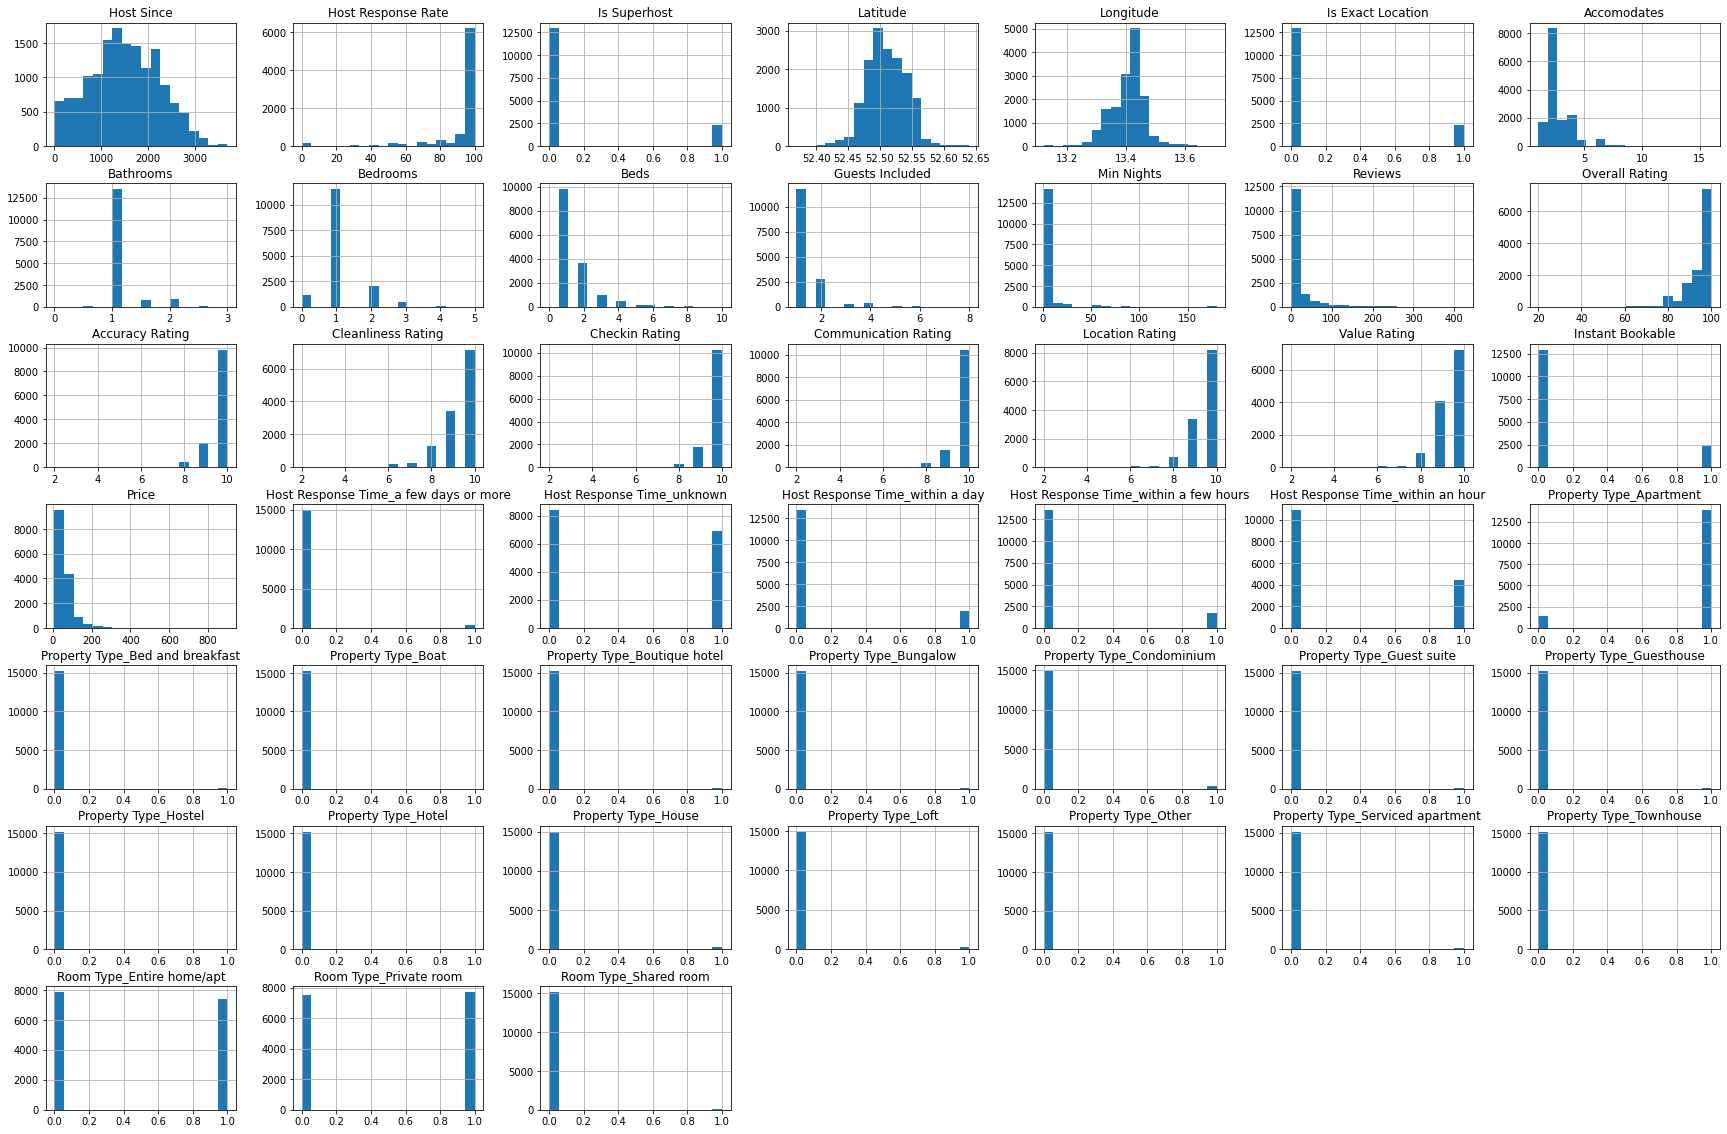

In [ ]:
# For phase 1
df_clean.hist(figsize=(30,20),bins=18)

### Phase 2 preprocessing

Let's add a feature: we process the host names through an NLP model to determine whether the host is a male or female.

In [ ]:
# Renaming  

## Loadings 
pred_model = load_model('/content/boyorgirl.h5')

## preprocess 

def preprocess(names_df):

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if type(x)!=type('hello') else x)
    print(names_df['Host Name'] )

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if  bool(re.match("^[A-Za-z0-9_-]*$",x))==False else x)
    print(names_df['Host Name'])

    names_df['name']= names_df['Host Name']
    names_df['name'] = names_df['name'].str.lower()

    names_df['name'] = [list(name) for name in names_df['name']]

    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]

    return names_df


### prediction 

df_clean_renamed = preprocess(df_clean)

result = pred_model.predict(np.array(df_clean_renamed['name'].tolist()))

df_clean_renamed['Boy or Girl?'] = [
        'Boy' if logit > 0.5 else 'Girl' for logit in result
    ]

df_clean_renamed.drop('name', axis=1, inplace=True)

dummies_gender = pd.get_dummies(df_clean_renamed[["Boy or Girl?"]])

X_ = df_clean_renamed.drop(["Boy or Girl?"],axis=1)
df_clean_2 = pd.concat([X_,  dummies_gender], axis=1)

0        Maximilian
1             Dulie
2             Geank
3              Alix
4            Lurina
            ...    
15687       Ascharl
15688         Marki
15689           Ada
15690         Lanna
15691        OloreA
Name: Host Name, Length: 15268, dtype: object
0        Maximilian
1             Dulie
2             Geank
3              Alix
4            Lurina
            ...    
15687       Ascharl
15688         Marki
15689           Ada
15690         Lanna
15691        OloreA
Name: Host Name, Length: 15268, dtype: object
478/478 [==============================] - 26s 52ms/step


In [ ]:
df_clean_2.drop('Host Name', axis=1, inplace=True)

Now let's add a feature representing the distance from an airbnb to the barycenter of airbnb locations.

In [ ]:
s_latitude = df_clean_2["Latitude"].sum()
s_longitude = df_clean_2["Longitude"].sum()

barycentre_lat = s_latitude/len(df_clean_2)
barycentre_long = s_longitude/len(df_clean_2)

df_clean_2["Distance from barycenter"] = np.sqrt((df_clean_2["Latitude"] - barycentre_lat)**2
                                              + (df_clean_2["Longitude"] - barycentre_long)**2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7561b25910>,
      dtype=object)

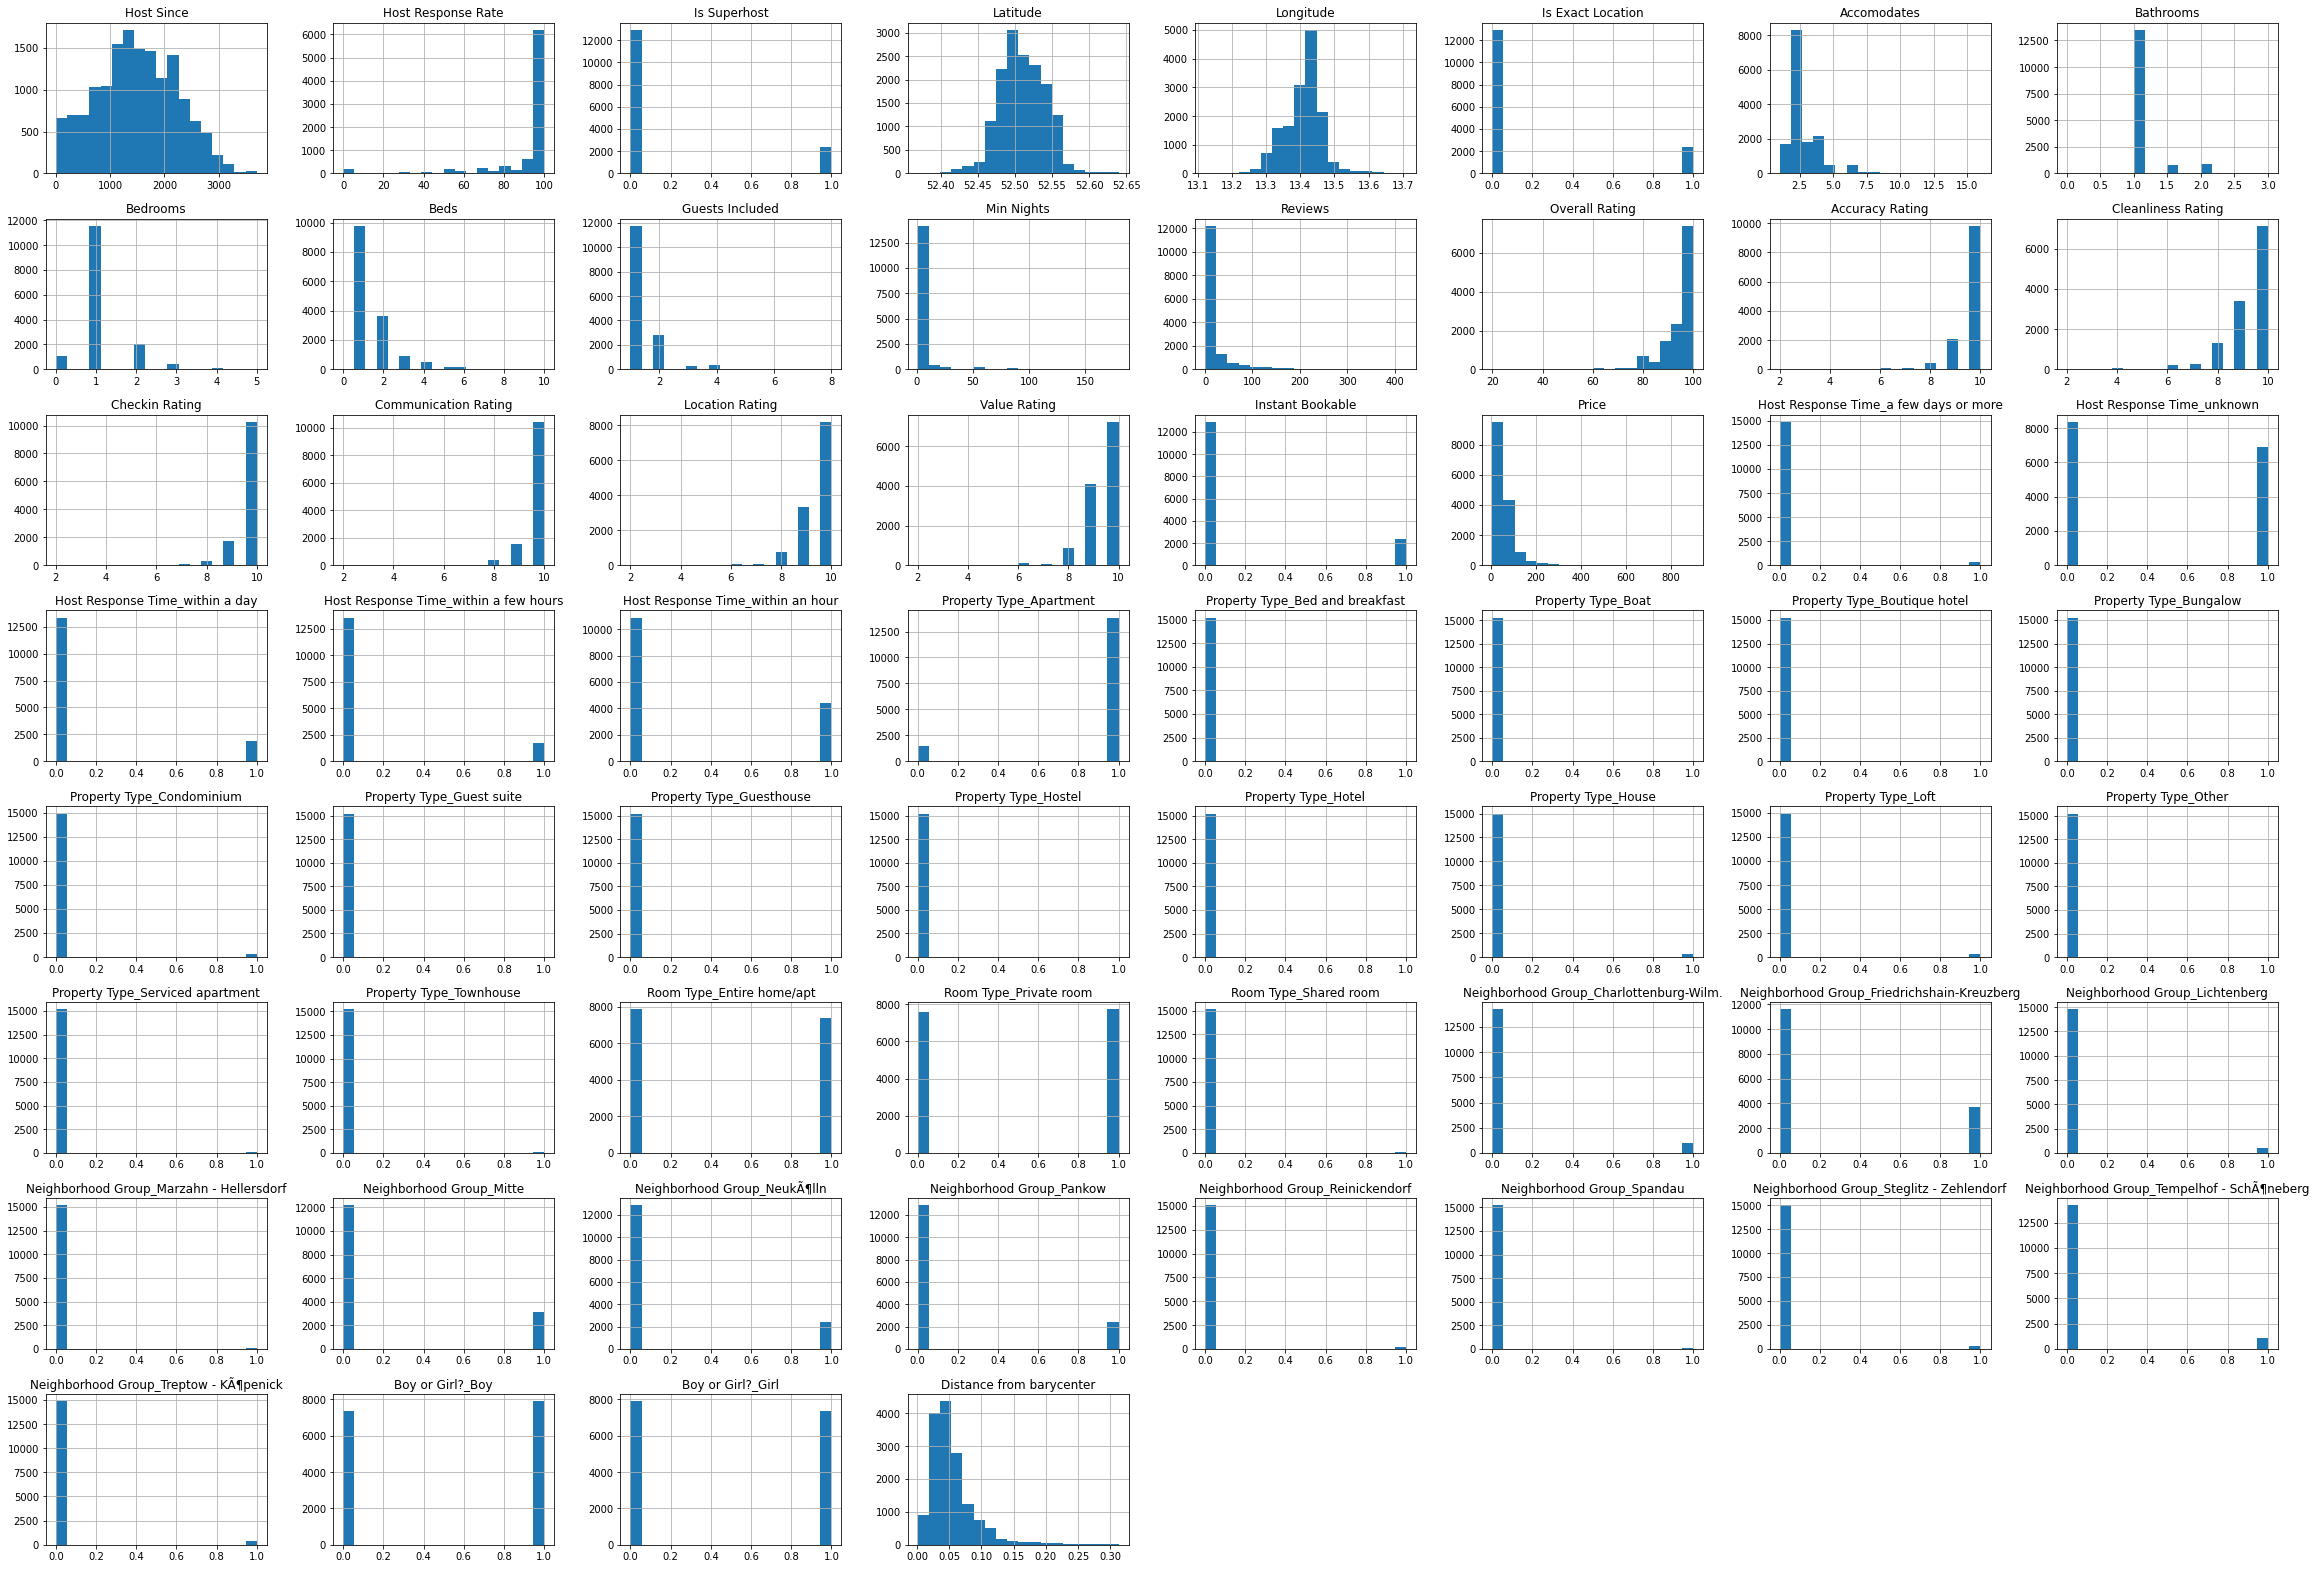

In [ ]:
df_clean_2.hist(figsize=(40,28), bins=18)

### Saving preprocessed data

In [ ]:
#df_clean.to_csv("/content/train_airbnb_berlin_preprocessed_phase1.csv", sep=";", index=False)
df_clean_2.to_csv("/content/train_airbnb_berlin_preprocessed_phase2.csv", sep=";", index=False)

## Data loading

In [ ]:
#df_clean = pd.read_csv("/content/train_airbnb_berlin_preprocessed_phase1.csv", sep=";")
df_clean_2 = pd.read_csv("/content/train_airbnb_berlin_preprocessed_phase2.csv", sep=";")


In [ ]:
#(15270, 45)
df_clean.shape

NameError: ignored

In [ ]:
# (15268, 60)

df_clean_2.shape

(10612, 60)

## Train test split

In [ ]:
# phase 1
from sklearn.model_selection import train_test_split

X = df_clean.drop("Price",axis=1)
y = df_clean["Price"].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)


In [ ]:
# phase 2
from sklearn.model_selection import train_test_split

X_2 = df_clean_2.drop("Price",axis=1)
y_2 = df_clean_2["Price"].copy()

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2,test_size=0.2,random_state=42)


In [ ]:
# We already have the processed version of X_train and X_test (phase 1)

X_train_processed = pd.read_csv("/content/X_train_processed.csv",sep=";")
X_test_processed = pd.read_csv("/content/X_test_processed.csv",sep=";")

FileNotFoundError: ignored

In [ ]:
# We already have the processed version of X_train and X_test (phase 2)

X_train_processed_2 = pd.read_csv("/content/X_train_processed_2.csv",sep=";")
X_test_processed_2 = pd.read_csv("/content/X_test_processed_2.csv",sep=";")

# KNN Regressor

## Missing value imputation & Scaling

Moving on, the strategy will be to make several versions of the processed data, so as to determine which type of processing yields the best results !

For imputing values, let's try two types of univariate imputation for now:
- mean
- median
- most frequent

For scaling:
- Minmax on every numeric data
- standard scaling on every numeric data

We're going to create the 6 pipelines that correspond to each combination:
- mn_minmax
- mdn_minmax
- mf_minmax
- mn_std
- mdn_std
- mf_std



### First approach

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipelines for numeric values

num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])

# Let's get the list of numerical features.
numeric_features = ['Host Since',
                    'Host Response Rate',
                    'Latitude',
                    'Longitude',
                    'Accomodates',
                    'Bathrooms',
                    'Bedrooms',
                    'Beds',
                    'Guests Included',
                    'Min Nights',
                    'Reviews',
                    'Overall Rating',
                    'Accuracy Rating',
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating',
                    'Value Rating'
                    ]

airbnb_data_transformer_1 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_2 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_3 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_4 = ColumnTransformer([
    ("num_mn_std", num_pipeline_mn_std, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_5 = ColumnTransformer([
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_6 = ColumnTransformer([
    ("num_mf_std", num_pipeline_mf_std, numeric_features)
],remainder="passthrough")



Now, out of these imputers and scalers, let's see which combination yields the best performance.

We'll keep parameters for KNN Regressor as identical (default), since we're trying to see which preprocessing technique seems best. Hyperparameter tuning will come later.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def train_test_knn_regressor(X_train, y_train, X_test, y_test):
    '''Trains and test a KNN regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (6 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the 6 types of full pipelines, combining the above preprocessors with KNN Regressor
    full_pipeline_1 = Pipeline([
      ("data_processing", airbnb_data_transformer_1),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_2 = Pipeline([
      ("data_processing", airbnb_data_transformer_2),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_3 = Pipeline([
      ("data_processing", airbnb_data_transformer_3),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_4 = Pipeline([
      ("data_processing", airbnb_data_transformer_4),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_5 = Pipeline([
      ("data_processing", airbnb_data_transformer_5),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_6 = Pipeline([
      ("data_processing", airbnb_data_transformer_6),
      ("knn_regression", KNeighborsRegressor())
    ])
    
    # Transform the training data and train the KNN regressor.
    full_pipeline_1.fit(X_train, y_train)
    full_pipeline_2.fit(X_train, y_train)
    full_pipeline_3.fit(X_train, y_train)
    full_pipeline_4.fit(X_train, y_train)
    full_pipeline_5.fit(X_train, y_train)
    full_pipeline_6.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_1 = full_pipeline_1.predict(X_test)
    predictions_2 = full_pipeline_2.predict(X_test)
    predictions_3 = full_pipeline_3.predict(X_test)
    predictions_4 = full_pipeline_4.predict(X_test)
    predictions_5 = full_pipeline_5.predict(X_test)
    predictions_6 = full_pipeline_6.predict(X_test)

    # Compute the prediction error.
    mse_1 =  mean_squared_error(y_test, predictions_1)
    mse_2 =  mean_squared_error(y_test, predictions_2)
    mse_3 =  mean_squared_error(y_test, predictions_3)
    mse_4 =  mean_squared_error(y_test, predictions_4)
    mse_5 =  mean_squared_error(y_test, predictions_5)
    mse_6 =  mean_squared_error(y_test, predictions_6)

    # Print the RMSE.
    print("The RMSE error using pipeline 1 is: ", np.sqrt(mse_1))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 2 is: ", np.sqrt(mse_2))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 3 is: ", np.sqrt(mse_3))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 4 is: ", np.sqrt(mse_4))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 5 is: ", np.sqrt(mse_5))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 6 is: ", np.sqrt(mse_6))
    print("--------------------------- \n")

In [ ]:
train_test_knn_regressor(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 1 is:  41.454277287579075
--------------------------- 

The RMSE error using pipeline 2 is:  41.065896060520075
--------------------------- 

The RMSE error using pipeline 3 is:  41.070373103051274
--------------------------- 

The RMSE error using pipeline 4 is:  41.13641640226373
--------------------------- 

The RMSE error using pipeline 5 is:  40.84295140858755
--------------------------- 

The RMSE error using pipeline 6 is:  40.84755886014494
--------------------------- 



From the above results, configurations 5 (median+std scaler) and 6 (most frequent+std scaler) seems to work the best. Let's see what a mix of min-max + std scaling gives.

### 2nd approach

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipelines for numeric values

num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])


# Let's get the list of numerical features that seem to have a Gaussian distribution
numeric_features_gaussian = ['Host Since',
                    'Latitude',
                    'Longitude',
                    ]

# And the remaining which will be processed by Min-max scaling.
numeric_features_nongaussian = [f for f in numeric_features if f not in numeric_features_gaussian]

airbnb_data_transformer_7 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features_nongaussian),
    ("num_mn_std", num_pipeline_mn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_8 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features_nongaussian),
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_9 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features_nongaussian),
    ("num_mf_std", num_pipeline_mf_std, numeric_features_gaussian)
],remainder="passthrough")




In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def train_test_knn_regressor_2(X_train, y_train, X_test, y_test):
    '''Trains and test a KNN regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (3 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the full pipeline, combining the above preprocessors with KNN Regressor
    full_pipeline_7 = Pipeline([
      ("data_processing", airbnb_data_transformer_7),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_8 = Pipeline([
      ("data_processing", airbnb_data_transformer_8),
      ("knn_regression", KNeighborsRegressor())
    ])
    full_pipeline_9 = Pipeline([
      ("data_processing", airbnb_data_transformer_9),
      ("knn_regression", KNeighborsRegressor())
    ])
    
    # Transform the training data and train the KNN regressor.
    full_pipeline_7.fit(X_train, y_train)
    full_pipeline_8.fit(X_train, y_train)
    full_pipeline_9.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_7 = full_pipeline_7.predict(X_test)
    predictions_8 = full_pipeline_8.predict(X_test)
    predictions_9 = full_pipeline_9.predict(X_test)

    # Compute the prediction error.
    mse_7 =  mean_squared_error(y_test, predictions_7)
    mse_8 =  mean_squared_error(y_test, predictions_8)
    mse_9 =  mean_squared_error(y_test, predictions_9)

    # Print the RMSE.
    print("The RMSE error using pipeline 7 is: ", np.sqrt(mse_7))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 8 is: ", np.sqrt(mse_8))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 9 is: ", np.sqrt(mse_9))
    print("--------------------------- \n")

In [ ]:
train_test_knn_regressor_2(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 7 is:  43.15811444183119
--------------------------- 

The RMSE error using pipeline 8 is:  42.96091688767515
--------------------------- 

The RMSE error using pipeline 9 is:  42.98004242844901
--------------------------- 



Well, this doesn't seem to be ideal. Our hypothesis seems false as all errors are much higher than the ones applying one scaling to everyone. Once again though, we can see that applying mean imputation works the best. 

Let's try one final approach, which is multivariate imputation, with the assumption missing data is MAR. Let's see what kind of result this yields.

### Stochastic imputation

In [ ]:
# Multivariate imputing (this cell has run)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

it_imp = IterativeImputer(sample_posterior=True)
X_it_imp = it_imp.fit_transform(pd.concat([X_train,y_train],axis=1))

In [ ]:
X_train_imputed = np.delete(X_it_imp,-1,axis=1)

In [ ]:
X_train_imputed_df = pd.DataFrame(X_train_imputed,
                                  columns=list(X_train.columns))

In [ ]:
X_train_imputed_df.head(5)

,Host Since,Host Response Rate,Is Superhost,Latitude,Longitude,Is Exact Location,Accomodates,Bathrooms,Bedrooms,Beds,...,Property Type_Hostel,Property Type_Hotel,Property Type_House,Property Type_Loft,Property Type_Other,Property Type_Serviced apartment,Property Type_Townhouse,Room Type_Entire home/apt,Room Type_Private room,Room Type_Shared room
0,2477.0,100.0,0.0,52.48081,13.42762,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1058.0,100.0,0.0,52.51957,13.34393,0.0,4.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1609.0,100.0,0.0,52.51129,13.38791,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1232.0,100.0,0.0,52.48244,13.32018,0.0,3.0,1.5,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1776.0,100.0,0.0,52.53975,13.42679,0.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfec2bbf90>,
      dtype=object)

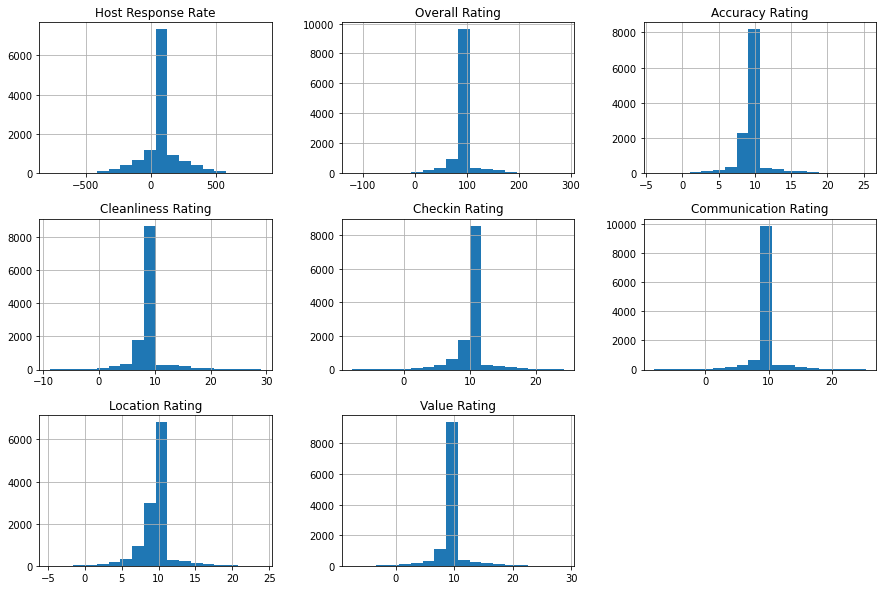

In [ ]:
X_train_imputed_df.hist(column=["Host Response Rate",
                                 "Overall Rating",
                                 "Accuracy Rating",
                                 "Cleanliness Rating",
                                 "Checkin Rating",
                                 "Communication Rating",
                                 "Location Rating",
                                 "Value Rating"], bins=18, figsize=(15,10))

New distribution shows this imputation is unusable. Aside from the fact that it has been done with a seemingly predominant constant value around 10/100, the values exceed the 100% mark, which doesn't make sense. 

Results show that simple is best, and a median imputation with standard scaling outputs the best result. 

### Constructing the processed data (phase 1)

In [ ]:
# The transformer reorders the features (numeric first then categorical)
# When reconstructing the dataframe, we need to take this into account!
categorical_features = [f for f in list(X_train.columns) if f not in numeric_features]

X_train_processed_arr = airbnb_data_transformer_5.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed_arr, 
                                 columns = numeric_features+categorical_features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe5a1cd10>,
      dtype=object)

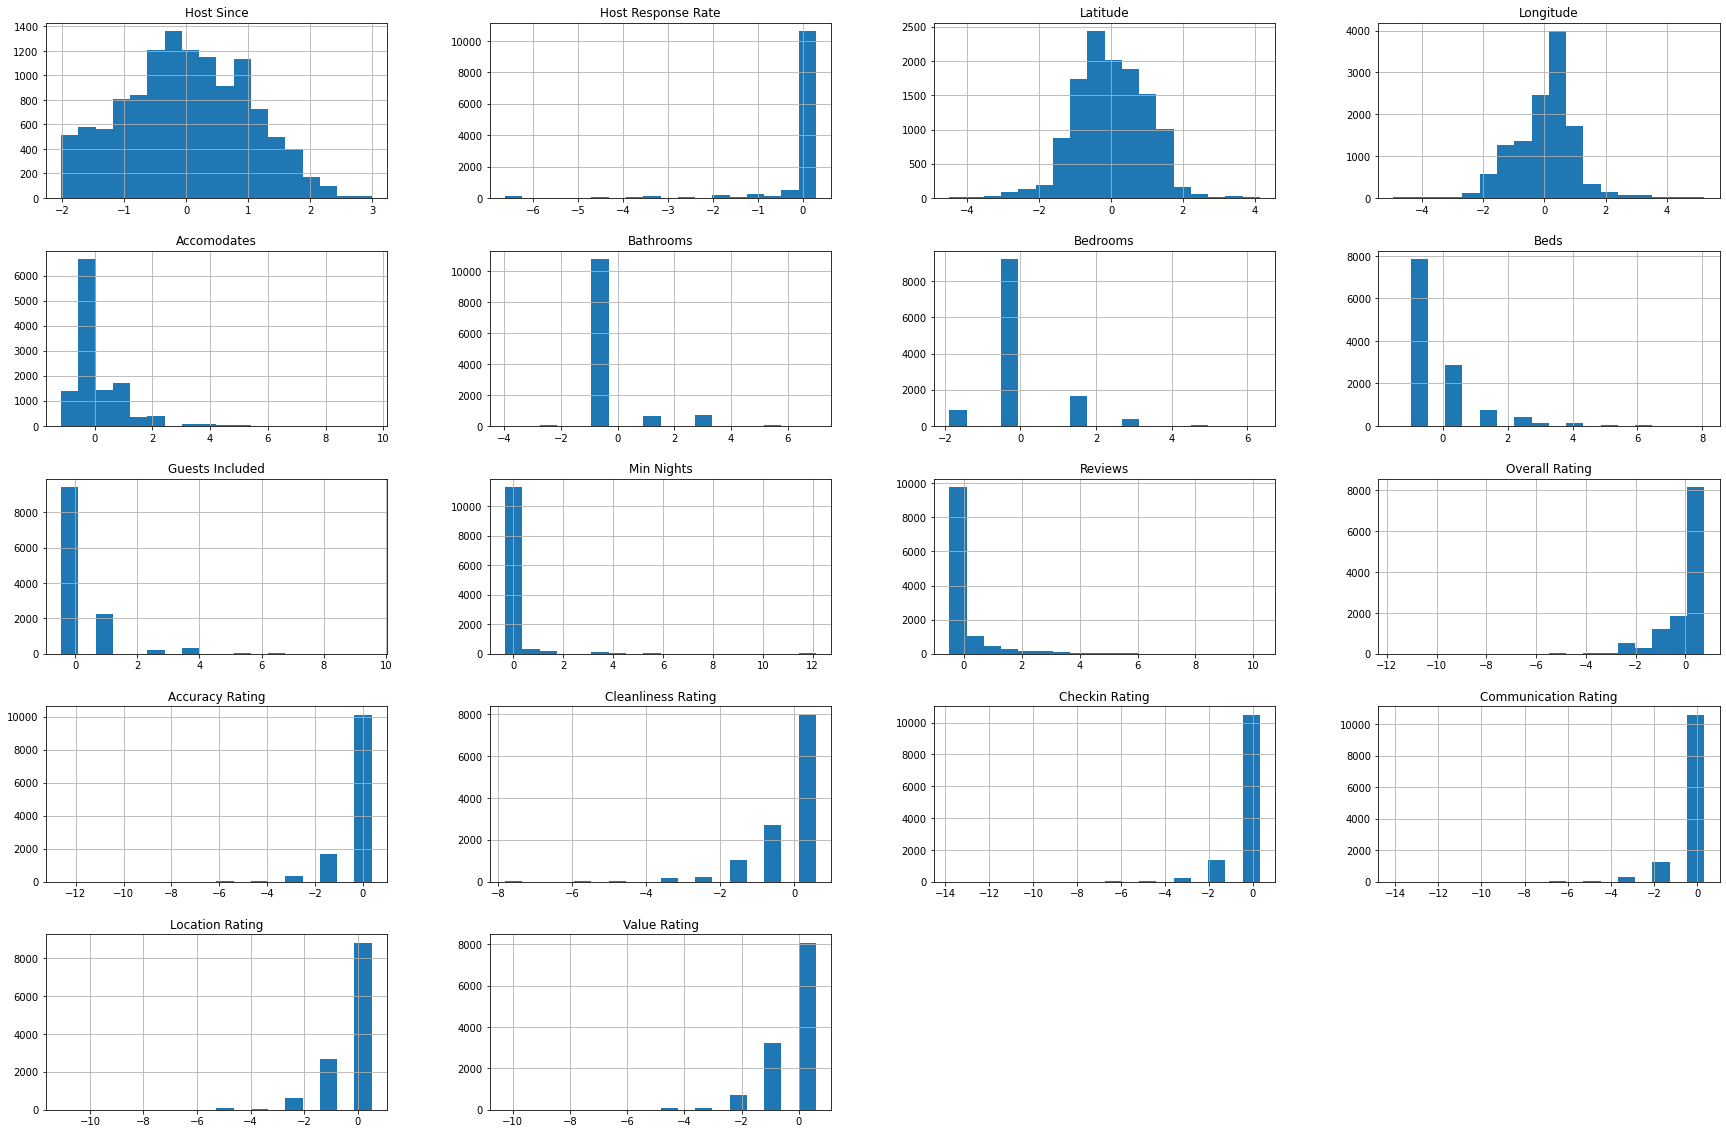

In [ ]:
X_train_processed.hist(figsize=(30,20), bins=18,column=numeric_features)

In [ ]:
# Likewise, let's build the processed version of X_test as well

categorical_features = [f for f in list(X_test.columns) if f not in numeric_features]

X_test_processed_arr = airbnb_data_transformer_5.fit_transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_arr, 
                                 columns = numeric_features+categorical_features)

In [ ]:
X_train_processed.to_csv("/content/X_train_processed.csv", sep=";", index=False)
X_test_processed.to_csv("/content/X_test_processed.csv", sep=";", index=False)


### Constructing the processed data (phase 2)

In [ ]:
# Keeping the same imputation and scaling strategies as the ones chosen in phase 1.



numeric_features_2 = ['Host Since',
                    'Host Response Rate',
                    'Latitude',
                    'Longitude',
                    'Accomodates',
                    'Bathrooms',
                    'Bedrooms',
                    'Beds',
                    'Guests Included',
                    'Min Nights',
                    'Reviews',
                    'Overall Rating',
                    'Accuracy Rating',
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating',
                    'Value Rating',
                    'Distance from barycenter'
                    ]

airbnb_data_transformer_5_bis = ColumnTransformer([
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features_2)
],remainder="passthrough")

categorical_features = [f for f in list(X_train_2.columns) if f not in numeric_features_2]

X_train_processed_arr_2 = airbnb_data_transformer_5_bis.fit_transform(X_train_2)
X_train_processed_2 = pd.DataFrame(X_train_processed_arr_2, 
                                 columns = numeric_features_2+categorical_features)

X_test_processed_arr_2 = airbnb_data_transformer_5_bis.fit_transform(X_test_2)
X_test_processed_2 = pd.DataFrame(X_test_processed_arr_2, 
                                 columns = numeric_features_2+categorical_features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f755d0ea110>,
      dtype=object)

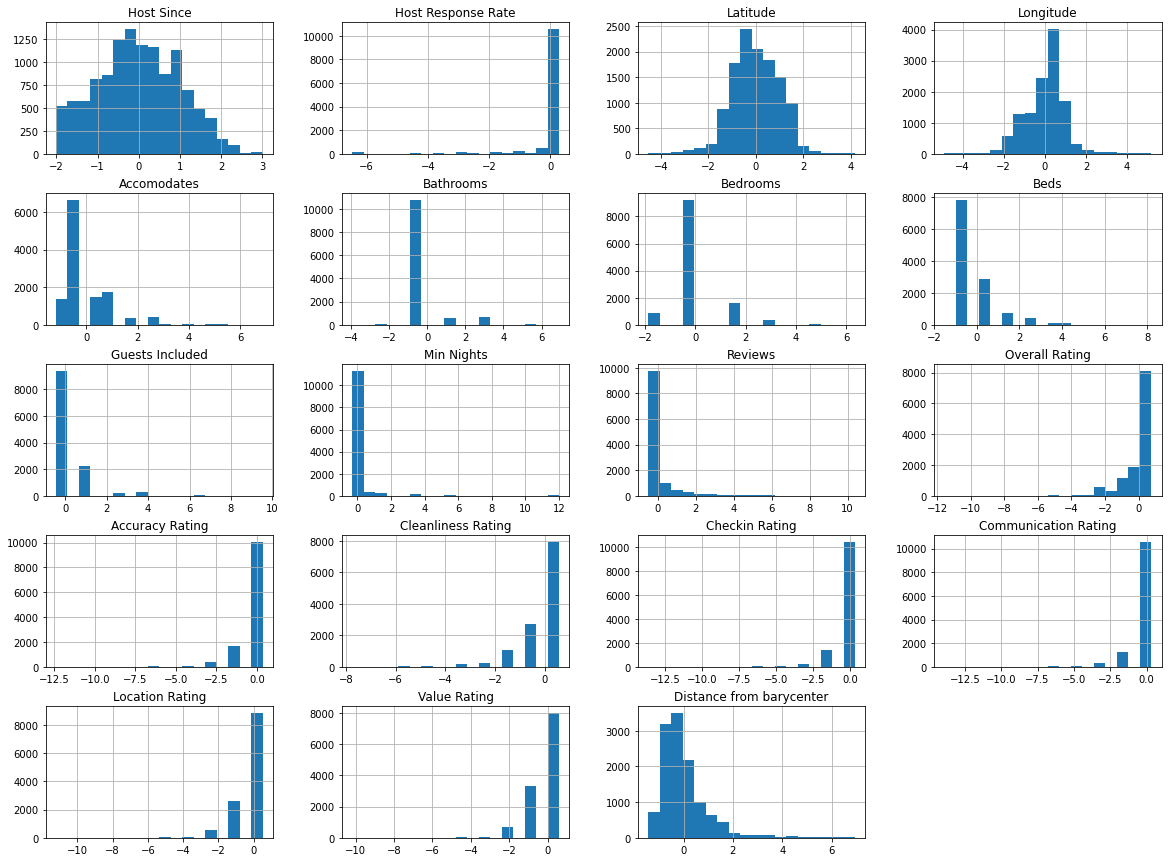

In [ ]:
X_train_processed_2.hist(column=numeric_features_2,bins=18, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f755b84c510>,
      dtype=object)

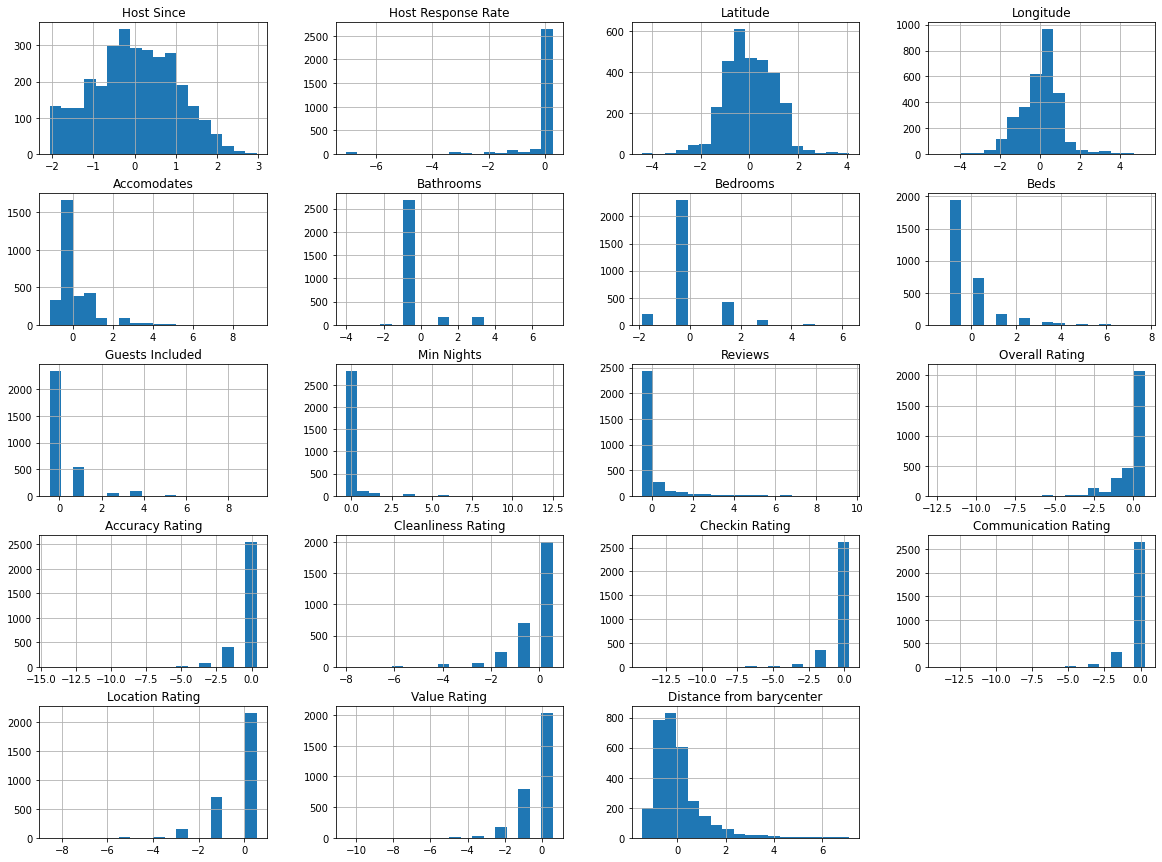

In [ ]:
X_test_processed_2.hist(column=numeric_features_2,bins=18, figsize=(20,15))

In [ ]:
X_train_processed_2.to_csv("/content/X_train_processed_2.csv", sep=";", index=False)
X_test_processed_2.to_csv("/content/X_test_processed_2.csv", sep=";", index=False)

## Feature Selection

In [ ]:
# define processing function that given a combination of features, returns its MSE metric

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

knn = KNeighborsRegressor()
kf_10 = model_selection.KFold(n_splits=10,shuffle=True, random_state=1)

def processSubset(feature_set):
    score = -1*model_selection.cross_val_score(knn, X_train_processed[list(feature_set)], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    return {"model":list(feature_set), "MSE":score}

In [ ]:
# define processing function that given a combination of features, returns its MSE metric (phase 2)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

knn = KNeighborsRegressor()
kf_10 = model_selection.KFold(n_splits=10,shuffle=True, random_state=1)

def processSubset_2(feature_set):
    score = -1*model_selection.cross_val_score(knn, X_train_processed_2[list(feature_set)], y_train_2.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    return {"model":list(feature_set), "MSE":score}

### Best Subset Selection

Let's brute force this by trying every single possible combination.

Caution: we're testing all possible k in 44 features combinations, so too high values of k might not be possible.

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def getBest(k):
    
    tic = time.time()
    
    results = []

    header = ["feature set", "RSS"]
    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/best_subset_selection.csv","w") as file:
        writer = csv.writer(file,delimiter=';')
        writer.writerow(header)
    
    for combo in itertools.combinations(X_train_processed.columns, k):
        processed = processSubset(combo)
        results.append(processed)
        with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/best_subset_selection.csv","a") as file:
            writer = csv.writer(file,delimiter=';')
            data_row = [processed["model"],processed["RSS"]]
            writer.writerow(data_row)      
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in tqdm(range(1,11)):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

 10%|█         | 1/10 [00:08<01:19,  8.78s/it]

Processed 44 models on 1 predictors in 8.775789260864258 seconds.


 20%|██        | 2/10 [02:32<11:43, 87.93s/it]

Processed 946 models on 2 predictors in 143.32683444023132 seconds.


 30%|███       | 3/10 [32:17<1:40:42, 863.15s/it]

Processed 13244 models on 3 predictors in 1785.6522369384766 seconds.


 30%|███       | 3/10 [47:30<1:50:51, 950.23s/it]


KeyboardInterrupt: ignored

Way too long for this naive approach, since the number of possible combinations explode as we have a lot of features to start with.

### Stepwise selection (forward)

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def forward(features):
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train_processed.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_fwd = pd.DataFrame(columns=["model","MSE"]) 

tic = time.time()
features = []
 
header = ["feature set", "RSS"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

for i in tqdm(range(1,len(X_train_processed.columns)+1)):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  2%|▏         | 1/44 [00:35<25:24, 35.45s/it]

Processed 44 models on 1 features in 35.440749406814575 seconds.
['Accomodates']


  5%|▍         | 2/44 [00:51<16:57, 24.23s/it]

Processed 43 models on 2 features in 16.359200954437256 seconds.
['Accomodates', 'Bathrooms']


  7%|▋         | 3/44 [01:11<15:00, 21.96s/it]

Processed 42 models on 3 features in 19.259372234344482 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt']


  9%|▉         | 4/44 [01:28<13:33, 20.35s/it]

Processed 41 models on 4 features in 17.867481470108032 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel']


 11%|█▏        | 5/44 [01:48<13:07, 20.20s/it]

Processed 40 models on 5 features in 19.916837453842163 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room']


 14%|█▎        | 6/44 [02:10<13:10, 20.80s/it]

Processed 39 models on 6 features in 21.949661016464233 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft']


 16%|█▌        | 7/44 [02:34<13:27, 21.82s/it]

Processed 38 models on 7 features in 23.916125059127808 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour']


 18%|█▊        | 8/44 [03:00<13:44, 22.91s/it]

Processed 37 models on 8 features in 25.24786114692688 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite']


 20%|██        | 9/44 [03:27<14:08, 24.25s/it]

Processed 36 models on 9 features in 27.164591312408447 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room']


 23%|██▎       | 10/44 [03:57<14:48, 26.15s/it]

Processed 35 models on 10 features in 30.392621994018555 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel']


 25%|██▌       | 11/44 [04:28<15:06, 27.45s/it]

Processed 34 models on 11 features in 30.411139011383057 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse']


 27%|██▋       | 12/44 [05:00<15:23, 28.85s/it]

Processed 33 models on 12 features in 32.01849961280823 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat']


 30%|██▉       | 13/44 [05:33<15:39, 30.29s/it]

Processed 32 models on 13 features in 33.615689516067505 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse']


 32%|███▏      | 14/44 [06:08<15:46, 31.56s/it]

Processed 31 models on 14 features in 34.486377000808716 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel']


 34%|███▍      | 15/44 [06:43<15:51, 32.82s/it]

Processed 30 models on 15 features in 35.71619534492493 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other']


 36%|███▋      | 16/44 [08:08<22:32, 48.30s/it]

Processed 29 models on 16 features in 84.22693610191345 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating']


 39%|███▊      | 17/44 [09:29<26:10, 58.18s/it]

Processed 28 models on 17 features in 81.14174461364746 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment']


 41%|████      | 18/44 [10:48<27:57, 64.51s/it]

Processed 27 models on 18 features in 79.25609707832336 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow']


 43%|████▎     | 19/44 [12:03<28:14, 67.79s/it]

Processed 26 models on 19 features in 75.39614224433899 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House']


 45%|████▌     | 20/44 [13:16<27:42, 69.29s/it]

Processed 25 models on 20 features in 72.77778649330139 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms']


 48%|████▊     | 21/44 [14:28<26:50, 70.04s/it]

Processed 24 models on 21 features in 71.78494811058044 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost']


 50%|█████     | 22/44 [15:37<25:33, 69.71s/it]

Processed 23 models on 22 features in 68.9408175945282 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day']


 52%|█████▏    | 23/44 [16:43<24:00, 68.58s/it]

Processed 22 models on 23 features in 65.9355936050415 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude']


 55%|█████▍    | 24/44 [17:46<22:16, 66.84s/it]

Processed 21 models on 24 features in 62.754361629486084 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included']


 57%|█████▋    | 25/44 [18:45<20:28, 64.65s/it]

Processed 20 models on 25 features in 59.540807485580444 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours']


 59%|█████▉    | 26/44 [19:42<18:40, 62.24s/it]

Processed 19 models on 26 features in 56.59362483024597 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment']


 61%|██████▏   | 27/44 [20:37<17:01, 60.08s/it]

Processed 18 models on 27 features in 55.05074167251587 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude']


 64%|██████▎   | 28/44 [21:27<15:13, 57.10s/it]

Processed 17 models on 28 features in 50.11831498146057 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews']


 66%|██████▌   | 29/44 [22:14<13:31, 54.12s/it]

Processed 16 models on 29 features in 47.17794871330261 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds']


 68%|██████▊   | 30/44 [22:59<11:56, 51.18s/it]

Processed 15 models on 30 features in 44.2898154258728 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate']


 70%|███████   | 31/44 [23:39<10:25, 48.10s/it]

Processed 14 models on 31 features in 40.897899866104126 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown']


 73%|███████▎  | 32/44 [24:19<09:05, 45.48s/it]

Processed 13 models on 32 features in 39.37090826034546 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights']


 75%|███████▌  | 33/44 [24:54<07:46, 42.41s/it]

Processed 12 models on 33 features in 35.238534927368164 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast']


 77%|███████▋  | 34/44 [25:27<06:34, 39.41s/it]

Processed 11 models on 34 features in 32.386942625045776 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more']


 80%|███████▉  | 35/44 [25:56<05:28, 36.50s/it]

Processed 10 models on 35 features in 29.696706295013428 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location']


 82%|████████▏ | 36/44 [26:23<04:29, 33.66s/it]

Processed 9 models on 36 features in 27.02113389968872 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable']


 84%|████████▍ | 37/44 [26:48<03:35, 30.84s/it]

Processed 8 models on 37 features in 24.25882053375244 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium']


 86%|████████▋ | 38/44 [27:10<02:50, 28.39s/it]

Processed 7 models on 38 features in 22.67769956588745 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating']


 89%|████████▊ | 39/44 [27:29<02:07, 25.40s/it]

Processed 6 models on 39 features in 18.419241428375244 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating', 'Value Rating']


 91%|█████████ | 40/44 [27:44<01:29, 22.46s/it]

Processed 5 models on 40 features in 15.586693048477173 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating', 'Value Rating', 'Checkin Rating

 93%|█████████▎| 41/44 [27:57<00:58, 19.48s/it]

Processed 4 models on 41 features in 12.498286724090576 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating', 'Value Rating', 'Checkin Rating

 95%|█████████▌| 42/44 [28:06<00:32, 16.46s/it]

Processed 3 models on 42 features in 9.406996726989746 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating', 'Value Rating', 'Checkin Rating'

 98%|█████████▊| 43/44 [28:12<00:13, 13.41s/it]

Processed 2 models on 43 features in 6.291218280792236 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating', 'Value Rating', 'Checkin Rating'

100%|██████████| 44/44 [28:16<00:00, 38.55s/it]

Processed 1 models on 44 features in 3.084491729736328 seconds.
['Accomodates', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel', 'Room Type_Shared room', 'Property Type_Loft', 'Host Response Time_within an hour', 'Property Type_Guest suite', 'Room Type_Private room', 'Property Type_Boutique hotel', 'Property Type_Townhouse', 'Property Type_Boat', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Other', 'Accuracy Rating', 'Property Type_Apartment', 'Property Type_Bungalow', 'Property Type_House', 'Bedrooms', 'Is Superhost', 'Host Response Time_within a day', 'Latitude', 'Guests Included', 'Host Response Time_within a few hours', 'Property Type_Serviced apartment', 'Longitude', 'Reviews', 'Beds', 'Host Response Rate', 'Host Response Time_unknown', 'Min Nights', 'Property Type_Bed and breakfast', 'Host Response Time_a few days or more', 'Is Exact Location', 'Instant Bookable', 'Property Type_Condominium', 'Overall Rating', 'Value Rating', 'Checkin Rating'

In [ ]:
models_fwd.loc[models_fwd['MSE'].idxmin()].MSE

1478.5079611303015

In [ ]:
models_fwd = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection.csv",sep=';')

In [ ]:
models_fwd=models_fwd.rename(columns={'RSS':'MSE'})

In [ ]:
best_features_fwd = eval(models_fwd.loc[models_fwd['MSE'].idxmin()]['feature set'])

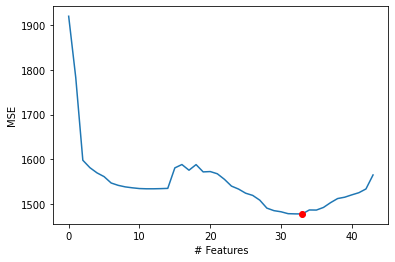

In [ ]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["MSE"])
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(models_fwd["MSE"].idxmin(), models_fwd["MSE"].min(), "or")

### Stepwise selction (forward) phase 2

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def forward_2(features):
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train_processed_2.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset_2(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models_2 = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model_2 = models_2.loc[models_2['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selectio_2.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model_2.model,best_model_2.MSE]
        writer.writerow(data_row)      

    print("Processed", models_2.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model_2


In [ ]:
models_fwd_2 = pd.DataFrame(columns=["model","MSE"]) 

tic = time.time()
features = []
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection_2.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

for i in tqdm(range(1,len(X_train_processed_2.columns)+1)):    
    models_fwd_2.loc[i] = forward_2(features)
    features = models_fwd_2.loc[i]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  2%|▏         | 1/59 [00:46<45:03, 46.62s/it]

Processed 59 models on 1 features in 46.607014417648315 seconds.
['Accomodates']


  3%|▎         | 2/59 [01:09<30:59, 32.63s/it]

Processed 58 models on 2 features in 22.821155786514282 seconds.
['Accomodates', 'Room Type_Private room']


  5%|▌         | 3/59 [01:29<25:05, 26.89s/it]

Processed 57 models on 3 features in 20.0488703250885 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick']


  7%|▋         | 4/59 [01:52<23:15, 25.38s/it]

Processed 56 models on 4 features in 23.04482364654541 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room']


  8%|▊         | 5/59 [02:19<23:11, 25.76s/it]

Processed 55 models on 5 features in 26.429546117782593 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment']


 10%|█         | 6/59 [02:48<23:56, 27.10s/it]

Processed 54 models on 6 features in 29.69077229499817 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel']


 12%|█▏        | 7/59 [03:24<25:49, 29.81s/it]

Processed 53 models on 7 features in 35.358075857162476 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost']


 14%|█▎        | 8/59 [04:01<27:31, 32.38s/it]

Processed 52 models on 8 features in 37.890530824661255 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse']


 15%|█▌        | 9/59 [04:54<32:20, 38.81s/it]

Processed 51 models on 9 features in 52.93206453323364 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment']


 17%|█▋        | 10/59 [05:39<33:12, 40.66s/it]

Processed 50 models on 10 features in 44.796884536743164 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg']


 19%|█▊        | 11/59 [06:30<34:57, 43.70s/it]

Processed 49 models on 11 features in 50.58358979225159 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House']


 20%|██        | 12/59 [07:15<34:41, 44.28s/it]

Processed 48 models on 12 features in 45.590088844299316 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau']


 22%|██▏       | 13/59 [08:10<36:13, 47.26s/it]

Processed 47 models on 13 features in 54.10015058517456 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf']


 24%|██▎       | 14/59 [09:05<37:13, 49.63s/it]

Processed 46 models on 14 features in 55.09692430496216 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more']


 25%|██▌       | 15/59 [09:58<37:15, 50.82s/it]

Processed 45 models on 15 features in 53.534714460372925 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel']


 27%|██▋       | 16/59 [12:11<54:04, 75.45s/it]

Processed 44 models on 16 features in 132.63649201393127 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms']


 29%|██▉       | 17/59 [14:20<1:04:12, 91.72s/it]

Processed 43 models on 17 features in 129.56223893165588 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow']


 31%|███       | 18/59 [16:29<1:10:17, 102.87s/it]

Processed 42 models on 18 features in 128.8204369544983 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt']


 32%|███▏      | 19/59 [18:34<1:12:55, 109.38s/it]

Processed 41 models on 19 features in 124.54333329200745 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.']


 34%|███▍      | 20/59 [20:38<1:13:55, 113.73s/it]

Processed 40 models on 20 features in 123.84101295471191 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating']


 36%|███▌      | 21/59 [22:36<1:12:57, 115.20s/it]

Processed 39 models on 21 features in 118.62360978126526 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg']


 37%|███▋      | 22/59 [24:33<1:11:15, 115.56s/it]

Processed 38 models on 22 features in 116.38893127441406 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating']


 39%|███▉      | 23/59 [26:28<1:09:15, 115.44s/it]

Processed 37 models on 23 features in 115.14528799057007 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg']


 41%|████      | 24/59 [28:18<1:06:25, 113.87s/it]

Processed 36 models on 24 features in 110.21141004562378 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf']


 42%|████▏     | 25/59 [30:07<1:03:43, 112.46s/it]

Processed 35 models on 25 features in 109.15753030776978 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow']


 44%|████▍     | 26/59 [31:54<1:00:57, 110.83s/it]

Processed 34 models on 26 features in 107.02698850631714 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel']


 46%|████▌     | 27/59 [33:39<58:12, 109.14s/it]  

Processed 33 models on 27 features in 105.17912769317627 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast']


 47%|████▋     | 28/59 [35:22<55:17, 107.02s/it]

Processed 32 models on 28 features in 102.05769395828247 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude']


 49%|████▉     | 29/59 [36:58<51:54, 103.82s/it]

Processed 31 models on 29 features in 96.34353566169739 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights']


 51%|█████     | 30/59 [38:33<48:51, 101.09s/it]

Processed 30 models on 30 features in 94.71952939033508 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location']


 53%|█████▎    | 31/59 [40:03<45:44, 98.01s/it] 

Processed 29 models on 31 features in 90.79475975036621 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other']


 54%|█████▍    | 32/59 [41:32<42:47, 95.11s/it]

Processed 28 models on 32 features in 88.32869529724121 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln']


 56%|█████▌    | 33/59 [42:57<39:53, 92.05s/it]

Processed 27 models on 33 features in 84.90762662887573 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat']


 58%|█████▊    | 34/59 [44:20<37:12, 89.28s/it]

Processed 26 models on 34 features in 82.79083347320557 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 59%|█████▉    | 35/59 [45:38<34:28, 86.18s/it]

Processed 25 models on 35 features in 78.9286379814148 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

 61%|██████    | 36/59 [46:55<31:56, 83.33s/it]

Processed 24 models on 36 features in 76.68635678291321 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 63%|██████▎   | 37/59 [48:08<29:23, 80.18s/it]

Processed 23 models on 37 features in 72.80244565010071 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 64%|██████▍   | 38/59 [49:16<26:49, 76.66s/it]

Processed 22 models on 38 features in 68.43788814544678 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 66%|██████▌   | 39/59 [50:24<24:36, 73.81s/it]

Processed 21 models on 39 features in 67.15784525871277 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 68%|██████▊   | 40/59 [51:28<22:29, 71.01s/it]

Processed 20 models on 40 features in 64.45471096038818 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 69%|██████▉   | 41/59 [52:31<20:35, 68.66s/it]

Processed 19 models on 41 features in 63.15826082229614 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 71%|███████   | 42/59 [53:28<18:27, 65.12s/it]

Processed 18 models on 42 features in 56.85154390335083 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 73%|███████▎  | 43/59 [54:22<16:30, 61.89s/it]

Processed 17 models on 43 features in 54.357393980026245 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', '

 75%|███████▍  | 44/59 [55:16<14:48, 59.27s/it]

Processed 16 models on 44 features in 53.12636470794678 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 76%|███████▋  | 45/59 [56:04<13:06, 56.15s/it]

Processed 15 models on 45 features in 48.866934061050415 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', '

 78%|███████▊  | 46/59 [56:50<11:28, 52.96s/it]

Processed 14 models on 46 features in 45.48971724510193 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 80%|███████▉  | 47/59 [57:33<09:59, 49.99s/it]

Processed 13 models on 47 features in 43.0434787273407 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

 81%|████████▏ | 48/59 [58:14<08:38, 47.17s/it]

Processed 12 models on 48 features in 40.603702783584595 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', '

 83%|████████▎ | 49/59 [58:50<07:20, 44.05s/it]

Processed 11 models on 49 features in 36.748518228530884 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', '

 85%|████████▍ | 50/59 [59:23<06:06, 40.70s/it]

Processed 10 models on 50 features in 32.88145613670349 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 86%|████████▋ | 51/59 [59:53<04:59, 37.42s/it]

Processed 9 models on 51 features in 29.73930788040161 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

 88%|████████▊ | 52/59 [1:00:20<04:00, 34.32s/it]

Processed 8 models on 52 features in 27.093543529510498 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 90%|████████▉ | 53/59 [1:00:45<03:09, 31.56s/it]

Processed 7 models on 53 features in 25.11478900909424 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

 92%|█████████▏| 54/59 [1:01:05<02:20, 28.10s/it]

Processed 6 models on 54 features in 20.007747173309326 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 93%|█████████▎| 55/59 [1:01:22<01:39, 24.77s/it]

Processed 5 models on 55 features in 16.95701003074646 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

 95%|█████████▍| 56/59 [1:01:36<01:04, 21.47s/it]

Processed 4 models on 56 features in 13.750558853149414 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 97%|█████████▋| 57/59 [1:01:46<00:36, 18.07s/it]

Processed 3 models on 57 features in 10.143428325653076 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'P

 98%|█████████▊| 58/59 [1:01:53<00:14, 14.70s/it]

Processed 2 models on 58 features in 6.832099914550781 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

100%|██████████| 59/59 [1:01:56<00:00, 63.00s/it]

Processed 1 models on 59 features in 3.264796257019043 seconds.
['Accomodates', 'Room Type_Private room', 'Neighborhood Group_Treptow - KÃ¶penick', 'Room Type_Shared room', 'Property Type_Serviced apartment', 'Property Type_Hotel', 'Is Superhost', 'Property Type_Guesthouse', 'Property Type_Apartment', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Property Type_House', 'Neighborhood Group_Spandau', 'Neighborhood Group_Marzahn - Hellersdorf', 'Host Response Time_a few days or more', 'Property Type_Boutique hotel', 'Bathrooms', 'Property Type_Bungalow', 'Room Type_Entire home/apt', 'Neighborhood Group_Charlottenburg-Wilm.', 'Location Rating', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Accuracy Rating', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Pankow', 'Property Type_Hostel', 'Property Type_Bed and breakfast', 'Latitude', 'Min Nights', 'Is Exact Location', 'Property Type_Other', 'Neighborhood Group_NeukÃ¶lln', 'Property Type_Boat', 'Pr

In [ ]:
models_fwd_2.loc[models_fwd_2['MSE'].idxmin()].MSE

1632.9476927795224

In [ ]:
best_features_fwd_2 = models_fwd_2.loc[models_fwd_2['MSE'].idxmin()]['model']
len(best_features_fwd_2)

34

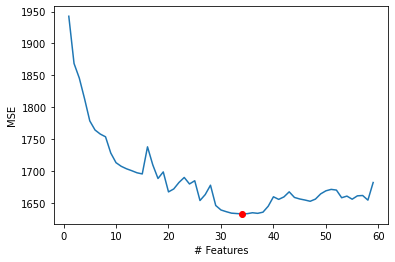

In [ ]:
import matplotlib.pyplot as plt

plt.plot(models_fwd_2["MSE"])
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(models_fwd_2["MSE"].idxmin(), models_fwd_2["MSE"].min(), "or")

### Stepwise selection (backward)

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def backward(features):
    
    # Pull out features we still need to process

    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest MSE
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_bwd = pd.DataFrame(columns=["model","MSE"], index=range(1,len(X_train_processed.columns))) 

tic = time.time()
features = X_train_processed.columns
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

while(len(features)>1):    
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 44 models on 43 features in 139.6476879119873 seconds.
['Host Response Rate', 'Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Host Response Time_a few days or more', 'Host Response Time_unknown', 'Host Response Time_within a day', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Apartment', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Condominium', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Hotel', 'Property Type_House', 'Property Type_Loft', 'Property Type_Other', 'Property Type_Serviced apartment', 'Property Type_Townhouse', 'Room Type_E

In [ ]:
models_bwd = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection.csv", sep=';')

In [ ]:
best_features_bwd = eval(models_bwd.loc[models_bwd["MSE"].idxmin()]['feature set'])
len(best_features_bwd)

18

In [ ]:
models_bwd["MSE"].min()

1484.025404753958

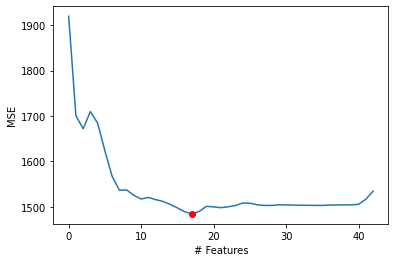

In [ ]:
import matplotlib.pyplot as plt

#when saving to pandas dataframe, order got inverted. We need to reorder.
plt.plot(list(models_bwd['MSE'].sort_index(ascending=False)))
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(42-models_bwd["MSE"].idxmin(), models_bwd["MSE"].min(), "or")

### Stepwise selection (backward) phase 2

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def backward_2(features):
    
    # Pull out features we still need to process

    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset_2(combo))
    
    # Wrap everything up in a nice dataframe
    models_2 = pd.DataFrame(results)
    
    
    # Choose the model with the lowest MSE
    best_model_2 = models_2.loc[models_2['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_2.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model_2.model,best_model_2.MSE]
        writer.writerow(data_row)      

    print("Processed", models_2.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model_2


In [ ]:
models_bwd_2 = pd.DataFrame(columns=["model","MSE"], index=range(1,len(X_train_processed_2.columns))) 

tic = time.time()
features = X_train_processed_2.columns
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_2.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

while(len(features)>1):    
    models_bwd_2.loc[len(features)-1] = backward_2(features)
    features = models_bwd_2.loc[len(features)-1]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 59 models on 58 features in 201.65648412704468 seconds.
['Host Response Rate', 'Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating', 'Distance from barycenter', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Host Response Time_a few days or more', 'Host Response Time_unknown', 'Host Response Time_within a day', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Apartment', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Condominium', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Hotel', 'Property Type_House', 'Property Type_Loft', 'Property Type_Other', 'Property Type_Serviced apartment', 'Property 

In [ ]:
best_features_bwd_2 = models_bwd_2.loc[models_bwd_2["MSE"].astype(float).idxmin()]['model']

In [ ]:
best_features_bwd_2

['Host Response Rate',
 'Latitude',
 'Longitude',
 'Accomodates',
 'Bathrooms',
 'Bedrooms',
 'Guests Included',
 'Cleanliness Rating',
 'Distance from barycenter',
 'Host Response Time_unknown',
 'Host Response Time_within an hour',
 'Property Type_Apartment',
 'Room Type_Entire home/apt',
 'Room Type_Private room',
 'Neighborhood Group_Mitte',
 'Boy or Girl?_Boy',
 'Boy or Girl?_Girl']

In [ ]:
len(best_features_bwd_2)

17

In [ ]:
models_bwd_2["MSE"].min()

1612.9953217976197

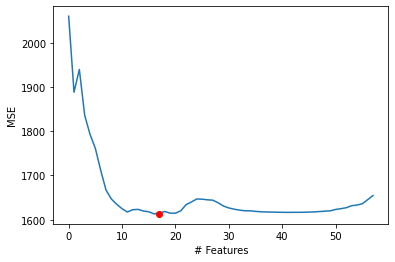

In [ ]:
import matplotlib.pyplot as plt

#when saving to pandas dataframe, order got inverted. We need to reorder.
plt.plot(list(models_bwd_2['MSE']))
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(models_bwd_2["MSE"].astype(float).idxmin(), models_bwd_2["MSE"].min(), "or")

### Arbitrary feature selection

In [ ]:
# Let's quickly look at the correlation matrix:

df_clean.drop("Price", axis=1).apply(lambda x: x.corr(df["Price"])).sort_values(ascending=False)


Accomodates                              0.505651
Beds                                     0.421559
Room Type_Entire home/apt                0.420660
Bedrooms                                 0.411953
Guests Included                          0.363908
Bathrooms                                0.253290
Property Type_Loft                       0.164815
Property Type_Serviced apartment         0.105193
Host Response Time_within an hour        0.104374
Location Rating                          0.078324
Is Superhost                             0.076663
Instant Bookable                         0.076663
Is Exact Location                        0.076663
Property Type_Hotel                      0.075534
Reviews                                  0.073858
Cleanliness Rating                       0.070996
Latitude                                 0.046966
Host Response Time_within a few hours    0.045625
Overall Rating                           0.043507
Property Type_Condominium                0.043441


In this first section, we'll focus on selecting the features that contribute most to the variance of the data, in order to limit the number of features.


In [ ]:
max_var_set = ['Accomodates','Beds','Room Type_Entire home/apt','Bedrooms','Room Type_Private room']

feature_selection_on_maxvar = processSubset(max_var_set)

In [ ]:
feature_selection_on_maxvar

{'model': ['Accomodates',
  'Beds',
  'Room Type_Entire home/apt',
  'Bedrooms',
  'Room Type_Private room'],
 'RSS': 5996422.5600000005}

Clearly a much higher RSS than stepwise selection methods. Let's now look at PCA.

### PCA

A point of contingency is what to do about categorical variables. Should we include them in the PCA scaling phase. Let's try out PCA with and without categorical data and compare their results.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_reduced = pca.fit_transform(X_train_processed)

[2531.6948899496133, 2578.0543752632266, 1792.754624713986, 1750.0401200513115, 1765.153661539534, 1751.2505349268326, 1757.7315230412682, 1702.1585208040956, 1690.012575649001, 1670.1293748624387, 1668.3565582288134, 1669.399421069634, 1673.8985269459313, 1673.2917302873473, 1662.212716736972, 1648.5431555444745, 1655.3953537694815, 1635.055823390717, 1626.9185468512703, 1625.1875482171652, 1628.3982523219543, 1606.9283062607317, 1597.2685471166747, 1605.257068821537, 1584.9352336243398, 1579.880718954038, 1576.6139684463515, 1576.1194018827637, 1578.3763832977452, 1573.856751842752, 1571.2245351895563, 1570.8784308587713, 1571.4253812321472, 1571.409625975328, 1571.4317931265591, 1571.1584947488777, 1565.6457967617966, 1565.4425462025033, 1565.527219265687, 1565.3684120633056, 1565.3684120633056, 1565.3684120633056, 1565.3684120633056, 1565.3684120633056, 1565.3684120633056]


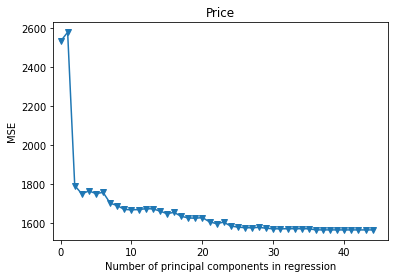

In [ ]:
from sklearn import model_selection

# 10_fold CV with shuffle
n = len(X_train_reduced)

kf_10 = model_selection.KFold(n_splits=10,shuffle=True, random_state=1)

knn = KNeighborsRegressor()
mse =[]

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(knn,np.ones((n,1)),y_train.ravel(),cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using CV for the 19 principal components, adding one component at the time.
for i in np.arange(1, 45):
    score = -1*model_selection.cross_val_score(knn, X_train_reduced[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1);

print(mse)


In [ ]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

[ 19.39  34.37  40.68  46.39  51.87  57.03  61.7   66.24  70.52  74.39
  78.15  81.38  83.88  86.3   88.53  90.6   92.38  94.07  95.54  96.66
  97.66  98.45  99.02  99.5   99.61  99.71  99.78  99.84  99.89  99.92
  99.94  99.96  99.97  99.98  99.99 100.   100.01 100.01 100.01 100.01
 100.01 100.01 100.01 100.01]


We can see that a lot of the variance is captured in the first 14~17 or so variables

In [ ]:
from sklearn.metrics import mean_squared_error


# Let's check performance on the test set!

X_test_reduced1 = pca.fit_transform(X_test_processed)[:,:14]
X_test_reduced2 = pca.fit_transform(X_test_processed)[:,:15]
X_test_reduced3 = pca.fit_transform(X_test_processed)[:,:16]
X_test_reduced4 = pca.fit_transform(X_test_processed)[:,:17]


knn_pca1 = KNeighborsRegressor()
knn_pca2 = KNeighborsRegressor()
knn_pca3 = KNeighborsRegressor()
knn_pca4 = KNeighborsRegressor()

knn_pca1.fit(X_train_reduced[:,:14],y_train)
knn_pca2.fit(X_train_reduced[:,:15],y_train)
knn_pca3.fit(X_train_reduced[:,:16],y_train)
knn_pca4.fit(X_train_reduced[:,:17],y_train)

pred1 = knn_pca1.predict(X_test_reduced1)
pred2 = knn_pca2.predict(X_test_reduced2)
pred3 = knn_pca3.predict(X_test_reduced3)
pred4 = knn_pca4.predict(X_test_reduced4)

print('MSE for PCA with 14 variables is: ', mean_squared_error(y_test,pred1))
print('MSE for PCA with 15 variables is: ', mean_squared_error(y_test,pred2))
print('MSE for PCA with 16 variables is: ', mean_squared_error(y_test,pred3))
print('MSE for PCA with 17 variables is: ', mean_squared_error(y_test,pred4))

MSE for PCA with 14 variables is:  1757.696751800917
MSE for PCA with 15 variables is:  1768.5360445317617
MSE for PCA with 16 variables is:  1744.490962671906
MSE for PCA with 17 variables is:  1793.5638506876228


The results are less good for PCA.

Clearly a much higher RSS than stepwise selection methods. Let's now look at PCA.

### PCA phase 2

A point of contingency is what to do about categorical variables. Should we include them in the PCA scaling phase. Let's try out PCA with and without categorical data and compare their results.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_reduced_2 = pca.fit_transform(X_train_processed_2)

[2432.8835836553712, 2750.211685924579, 1941.2164775217116, 1923.1136632552802, 1926.7333609756163, 1898.6602809132596, 1882.4160535205642, 1899.0690264694094, 1809.1362436011373, 1798.1991400786294, 1769.0416532342492, 1772.0312885577143, 1804.0647316907744, 1796.708390281369, 1826.6623586660608, 1822.3331002304192, 1790.0548745856402, 1778.9805340046191, 1776.8396018074316, 1736.1148440265886, 1717.9662753960624, 1716.898443911848, 1729.1990434097243, 1726.8146789985942, 1726.8014522881756, 1735.1067039090872, 1733.1010210487234, 1730.7654148929469, 1706.5647874793406, 1697.7347327792008, 1698.4245738662335, 1697.4343763972277, 1694.6742290199738, 1693.3244298105576, 1693.73833143931, 1692.0764721358767, 1690.3938455399307, 1693.0900378804631, 1690.524005552048, 1684.9518415159691, 1685.4242133477026, 1686.3014671508288, 1684.6784263227669, 1685.3276022846235, 1684.723148241829]


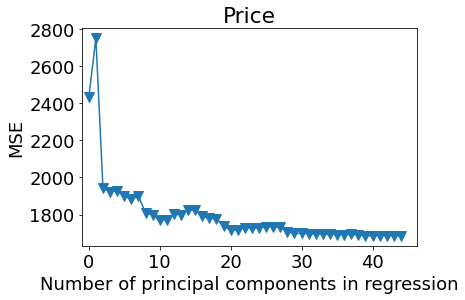

In [ ]:
from sklearn import model_selection

# 10_fold CV with shuffle
n = len(X_train_reduced_2)

kf_10 = model_selection.KFold(n_splits=10,shuffle=True, random_state=1)

knn = KNeighborsRegressor()
mse =[]

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(knn,np.ones((n,1)),y_train_2.ravel(),cv=kf_10, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using CV for the 19 principal components, adding one component at the time.
for i in np.arange(1, 45):
    score = -1*model_selection.cross_val_score(knn, X_train_reduced_2[:,:i], y_train_2.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Price')
plt.xlim(xmin=-1);

print(mse)


In [ ]:
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

[17.32 30.61 36.69 42.33 47.65 52.5  57.15 61.39 65.25 68.99 72.49 75.38
 78.17 80.46 82.68 84.84 86.88 88.73 90.32 91.82 93.1  94.1  95.02 95.93
 96.69 97.4  97.91 98.33 98.73 98.99 99.21 99.35 99.45 99.54 99.62 99.69
 99.74 99.79 99.83 99.86 99.88 99.9  99.92 99.93 99.94 99.95 99.96 99.97
 99.98 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99 99.99]


We can see that a lot of the variance is captured in the first 16~19 or so variables

In [ ]:
from sklearn.metrics import mean_squared_error


# Let's check performance on the test set!

X_test_reduced1 = pca.fit_transform(X_test_processed_2)[:,:16]
X_test_reduced2 = pca.fit_transform(X_test_processed_2)[:,:17]
X_test_reduced3 = pca.fit_transform(X_test_processed_2)[:,:18]
X_test_reduced4 = pca.fit_transform(X_test_processed_2)[:,:19]


knn_pca1 = KNeighborsRegressor()
knn_pca2 = KNeighborsRegressor()
knn_pca3 = KNeighborsRegressor()
knn_pca4 = KNeighborsRegressor()

knn_pca1.fit(X_train_reduced_2[:,:16],y_train_2)
knn_pca2.fit(X_train_reduced_2[:,:17],y_train_2)
knn_pca3.fit(X_train_reduced_2[:,:18],y_train_2)
knn_pca4.fit(X_train_reduced_2[:,:19],y_train_2)

pred1 = knn_pca1.predict(X_test_reduced1)
pred2 = knn_pca2.predict(X_test_reduced2)
pred3 = knn_pca3.predict(X_test_reduced3)
pred4 = knn_pca4.predict(X_test_reduced4)

print('MSE for PCA with 16 variables is: ', mean_squared_error(y_test_2,pred1))
print('MSE for PCA with 17 variables is: ', mean_squared_error(y_test_2,pred2))
print('MSE for PCA with 18 variables is: ', mean_squared_error(y_test_2,pred3))
print('MSE for PCA with 19 variables is: ', mean_squared_error(y_test_2,pred4))

MSE for PCA with 16 variables is:  1522.102003929273
MSE for PCA with 17 variables is:  1502.8077930582842
MSE for PCA with 18 variables is:  1515.7608382449246
MSE for PCA with 19 variables is:  1572.4453962017028


The results are less good for PCA.

## Fine-tuning the model

In [ ]:
best_features_fwd

['Accomodates',
 'Bathrooms',
 'Room Type_Entire home/apt',
 'Property Type_Hotel',
 'Room Type_Shared room',
 'Property Type_Loft',
 'Host Response Time_within an hour',
 'Property Type_Guest suite',
 'Room Type_Private room',
 'Property Type_Boutique hotel',
 'Property Type_Townhouse',
 'Property Type_Boat',
 'Property Type_Guesthouse',
 'Property Type_Hostel',
 'Property Type_Other',
 'Accuracy Rating',
 'Property Type_Apartment',
 'Property Type_Bungalow',
 'Property Type_House',
 'Bedrooms',
 'Is Superhost',
 'Host Response Time_within a day',
 'Latitude',
 'Guests Included',
 'Host Response Time_within a few hours',
 'Property Type_Serviced apartment',
 'Longitude',
 'Reviews',
 'Beds',
 'Host Response Rate',
 'Host Response Time_unknown',
 'Min Nights',
 'Property Type_Bed and breakfast',
 'Host Response Time_a few days or more']

In [ ]:
# obtained for phase 2 config
best_features_fwd_2

['Accomodates',
 'Room Type_Private room',
 'Neighborhood Group_Treptow - KÃ¶penick',
 'Room Type_Shared room',
 'Property Type_Serviced apartment',
 'Property Type_Hotel',
 'Is Superhost',
 'Property Type_Guesthouse',
 'Property Type_Apartment',
 'Neighborhood Group_Tempelhof - SchÃ¶neberg',
 'Property Type_House',
 'Neighborhood Group_Spandau',
 'Neighborhood Group_Marzahn - Hellersdorf',
 'Host Response Time_a few days or more',
 'Property Type_Boutique hotel',
 'Bathrooms',
 'Property Type_Bungalow',
 'Room Type_Entire home/apt',
 'Neighborhood Group_Charlottenburg-Wilm.',
 'Location Rating',
 'Neighborhood Group_Friedrichshain-Kreuzberg',
 'Accuracy Rating',
 'Neighborhood Group_Lichtenberg',
 'Neighborhood Group_Reinickendorf',
 'Neighborhood Group_Pankow',
 'Property Type_Hostel',
 'Property Type_Bed and breakfast',
 'Latitude',
 'Min Nights',
 'Is Exact Location',
 'Property Type_Other',
 'Neighborhood Group_NeukÃ¶lln',
 'Property Type_Boat',
 'Property Type_Townhouse']

In [ ]:
best_features_bwd

['Host Response Rate',
 'Latitude',
 'Longitude',
 'Accomodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Guests Included',
 'Overall Rating',
 'Is Superhost',
 'Host Response Time_unknown',
 'Host Response Time_within a few hours',
 'Host Response Time_within an hour',
 'Property Type_Apartment',
 'Property Type_Hotel',
 'Property Type_Loft',
 'Room Type_Entire home/apt',
 'Room Type_Private room']

In [ ]:
# obtained for phase 2
best_features_bwd_2

['Host Response Rate',
 'Latitude',
 'Longitude',
 'Accomodates',
 'Bathrooms',
 'Bedrooms',
 'Guests Included',
 'Cleanliness Rating',
 'Distance from barycenter',
 'Host Response Time_unknown',
 'Host Response Time_within an hour',
 'Property Type_Apartment',
 'Room Type_Entire home/apt',
 'Room Type_Private room',
 'Neighborhood Group_Mitte',
 'Boy or Girl?_Boy',
 'Boy or Girl?_Girl']

We've obtained two subsets that seem to deliver positive results. The one obtained with the backward method seems to be more concise since it has less features (although the overall MSE is greater). Let's keep it in a first tentative to fine-tune KNN's parameters!

### First tentative

We'll try to fine-tune by doing a CV grid search on the following hyperparameters:
- weights (uniform or distance)
- n_neighbors
- leaf_size

We'll leave metric params (i.e. Minkowski) as is for now.

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {"n_neighbors":[1,10,20,30],
         "weights":['uniform','distance'],
         "leaf_size":[10,20,30,40,50]}

grid_search = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid,cv=10,verbose=11)
grid_search.fit(X_train_processed[best_features_bwd],y_train)



Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV 1/10; 1/40] START leaf_size=10, n_neighbors=1, weights=uniform..............
[CV 1/10; 1/40] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.080 total time=   0.2s
[CV 2/10; 1/40] START leaf_size=10, n_neighbors=1, weights=uniform..............
[CV 2/10; 1/40] END leaf_size=10, n_neighbors=1, weights=uniform;, score=-0.144 total time=   0.2s
[CV 3/10; 1/40] START leaf_size=10, n_neighbors=1, weights=uniform..............
[CV 3/10; 1/40] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.065 total time=   0.2s
[CV 4/10; 1/40] START leaf_size=10, n_neighbors=1, weights=uniform..............
[CV 4/10; 1/40] END leaf_size=10, n_neighbors=1, weights=uniform;, score=0.018 total time=   0.2s
[CV 5/10; 1/40] START leaf_size=10, n_neighbors=1, weights=uniform..............
[CV 5/10; 1/40] END leaf_size=10, n_neighbors=1, weights=uniform;, score=-0.055 total time=   0.2s
[CV 6/10; 1/40] START leaf_size=10, n_ne

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [10, 20, 30, 40, 50],
                         'n_neighbors': [1, 10, 20, 30],
                         'weights': ['uniform', 'distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search.best_score_ * 100)

Best leaf_size: 10
Best weighting algorithm: distance
Best n_neighbors: 30
Accuracy:  38.43982844373958


In [ ]:
pgrid2 = {"n_neighbors":[25,30,35],
         "weights":['uniform','distance'],
         "leaf_size":[5,10,15]}

grid_search2 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid2,cv=10,verbose=11)
grid_search2.fit(X_train_processed[best_features_bwd],y_train)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START leaf_size=5, n_neighbors=25, weights=uniform..............
[CV 1/10; 1/18] END leaf_size=5, n_neighbors=25, weights=uniform;, score=0.442 total time=   0.3s
[CV 2/10; 1/18] START leaf_size=5, n_neighbors=25, weights=uniform..............
[CV 2/10; 1/18] END leaf_size=5, n_neighbors=25, weights=uniform;, score=0.411 total time=   0.3s
[CV 3/10; 1/18] START leaf_size=5, n_neighbors=25, weights=uniform..............
[CV 3/10; 1/18] END leaf_size=5, n_neighbors=25, weights=uniform;, score=0.364 total time=   0.3s
[CV 4/10; 1/18] START leaf_size=5, n_neighbors=25, weights=uniform..............
[CV 4/10; 1/18] END leaf_size=5, n_neighbors=25, weights=uniform;, score=0.352 total time=   0.3s
[CV 5/10; 1/18] START leaf_size=5, n_neighbors=25, weights=uniform..............
[CV 5/10; 1/18] END leaf_size=5, n_neighbors=25, weights=uniform;, score=0.397 total time=   0.3s
[CV 6/10; 1/18] START leaf_size=5, n_neigh

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [5, 10, 15], 'n_neighbors': [25, 30, 35],
                         'weights': ['uniform', 'distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search2.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search2.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search2.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search2.best_score_ * 100)

Best leaf_size: 5
Best weighting algorithm: distance
Best n_neighbors: 35
Accuracy:  38.54084384130275


In [ ]:
pgrid3 = {"n_neighbors":[33,35,37],
         "weights":['uniform','distance'],
         "leaf_size":[2,5,7]}

grid_search3 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid3,cv=10,verbose=11)
grid_search3.fit(X_train_processed[best_features_bwd],y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START leaf_size=2, n_neighbors=33, weights=uniform..............
[CV 1/10; 1/18] END leaf_size=2, n_neighbors=33, weights=uniform;, score=0.444 total time=   0.4s
[CV 2/10; 1/18] START leaf_size=2, n_neighbors=33, weights=uniform..............
[CV 2/10; 1/18] END leaf_size=2, n_neighbors=33, weights=uniform;, score=0.422 total time=   0.4s
[CV 3/10; 1/18] START leaf_size=2, n_neighbors=33, weights=uniform..............
[CV 3/10; 1/18] END leaf_size=2, n_neighbors=33, weights=uniform;, score=0.356 total time=   0.3s
[CV 4/10; 1/18] START leaf_size=2, n_neighbors=33, weights=uniform..............
[CV 4/10; 1/18] END leaf_size=2, n_neighbors=33, weights=uniform;, score=0.353 total time=   0.3s
[CV 5/10; 1/18] START leaf_size=2, n_neighbors=33, weights=uniform..............
[CV 5/10; 1/18] END leaf_size=2, n_neighbors=33, weights=uniform;, score=0.398 total time=   0.3s
[CV 6/10; 1/18] START leaf_size=2, n_neigh

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [2, 5, 7], 'n_neighbors': [33, 35, 37],
                         'weights': ['uniform', 'distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search3.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search3.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search3.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search3.best_score_ * 100)

Best leaf_size: 2
Best weighting algorithm: distance
Best n_neighbors: 37
Accuracy:  38.556245101804876


In [ ]:
pgrid4 = {"n_neighbors":[40,50,60],
         "weights":['uniform','distance'],
         "leaf_size":[1,2,3]}

grid_search4 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid4,cv=10,verbose=11)
grid_search4.fit(X_train_processed[best_features_bwd],y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 1/10; 1/18] START leaf_size=1, n_neighbors=40, weights=uniform..............
[CV 1/10; 1/18] END leaf_size=1, n_neighbors=40, weights=uniform;, score=0.442 total time=   0.3s
[CV 2/10; 1/18] START leaf_size=1, n_neighbors=40, weights=uniform..............
[CV 2/10; 1/18] END leaf_size=1, n_neighbors=40, weights=uniform;, score=0.421 total time=   0.3s
[CV 3/10; 1/18] START leaf_size=1, n_neighbors=40, weights=uniform..............
[CV 3/10; 1/18] END leaf_size=1, n_neighbors=40, weights=uniform;, score=0.354 total time=   0.3s
[CV 4/10; 1/18] START leaf_size=1, n_neighbors=40, weights=uniform..............
[CV 4/10; 1/18] END leaf_size=1, n_neighbors=40, weights=uniform;, score=0.356 total time=   0.3s
[CV 5/10; 1/18] START leaf_size=1, n_neighbors=40, weights=uniform..............
[CV 5/10; 1/18] END leaf_size=1, n_neighbors=40, weights=uniform;, score=0.396 total time=   0.3s
[CV 6/10; 1/18] START leaf_size=1, n_neigh

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1, 2, 3], 'n_neighbors': [40, 50, 60],
                         'weights': ['uniform', 'distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search4.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search4.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search4.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search4.best_score_ * 100)

Best leaf_size: 1
Best weighting algorithm: distance
Best n_neighbors: 50
Accuracy:  38.579836030747636


In [ ]:
pgrid5 = {"n_neighbors":[45,47,50,52,55],
         "weights":['uniform','distance'],
         "leaf_size":[1]}

grid_search5 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid5,cv=10,verbose=11)
grid_search5.fit(X_train_processed[best_features_bwd],y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10; 1/10] START leaf_size=1, n_neighbors=45, weights=uniform..............
[CV 1/10; 1/10] END leaf_size=1, n_neighbors=45, weights=uniform;, score=0.440 total time=   0.5s
[CV 2/10; 1/10] START leaf_size=1, n_neighbors=45, weights=uniform..............
[CV 2/10; 1/10] END leaf_size=1, n_neighbors=45, weights=uniform;, score=0.424 total time=   0.5s
[CV 3/10; 1/10] START leaf_size=1, n_neighbors=45, weights=uniform..............
[CV 3/10; 1/10] END leaf_size=1, n_neighbors=45, weights=uniform;, score=0.354 total time=   0.4s
[CV 4/10; 1/10] START leaf_size=1, n_neighbors=45, weights=uniform..............
[CV 4/10; 1/10] END leaf_size=1, n_neighbors=45, weights=uniform;, score=0.353 total time=   0.5s
[CV 5/10; 1/10] START leaf_size=1, n_neighbors=45, weights=uniform..............
[CV 5/10; 1/10] END leaf_size=1, n_neighbors=45, weights=uniform;, score=0.394 total time=   0.4s
[CV 6/10; 1/10] START leaf_size=1, n_neigh

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1], 'n_neighbors': [45, 47, 50, 52, 55],
                         'weights': ['uniform', 'distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search5.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search5.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search5.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search5.best_score_ * 100)

Best leaf_size: 1
Best weighting algorithm: distance
Best n_neighbors: 50
Accuracy:  38.579836030747636


In [ ]:
pgrid6 = {"n_neighbors":[47,48,49,50,51,52],
         "weights":['distance'],
         "leaf_size":[1]}

grid_search6 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid6,cv=10,verbose=11)
grid_search6.fit(X_train_processed[best_features_bwd],y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 1/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.444 total time=   0.3s
[CV 2/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 2/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.422 total time=   0.3s
[CV 3/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 3/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.358 total time=   0.3s
[CV 4/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 4/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.354 total time=   0.3s
[CV 5/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 5/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.396 total time=   0.3s
[CV 6/10; 1/6] START leaf_size=1, n_neighbor

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1],
                         'n_neighbors': [47, 48, 49, 50, 51, 52],
                         'weights': ['distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search6.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search6.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search6.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search6.best_score_ * 100)

Best leaf_size: 1
Best weighting algorithm: distance
Best n_neighbors: 50
Accuracy:  38.579836030747636


In [ ]:
knn = KNeighborsRegressor(leaf_size=1,weights='distance',n_neighbors=50)

knn.fit(X_train_processed[best_features_bwd],y_train)
predictions_knn = knn.predict(X_test_processed[best_features_bwd])
mse_knn = mean_squared_error(y_test,predictions_knn)

print("First MSE result after fine-tuning:", mse_knn)
print("First RMSE (average price prediction result) result after fine-tuning:", np.sqrt(mse_knn))


First MSE result after fine-tuning: 1499.1525502757381
First RMSE (average price prediction result) result after fine-tuning: 38.718891387483424


In [ ]:
knn2 = KNeighborsRegressor(leaf_size=1,weights='distance',n_neighbors=50)

knn2.fit(X_train_processed[best_features_fwd],y_train)
predictions_knn2 = knn2.predict(X_test_processed[best_features_fwd])
mse_knn2 = mean_squared_error(y_test,predictions_knn2)

print("First MSE result after fine-tuning:", mse_knn2)
print("First RMSE (average price prediction result) result after fine-tuning:", np.sqrt(mse_knn2))

First MSE result after fine-tuning: 1501.9375052018659
First RMSE (average price prediction result) result after fine-tuning: 38.754838474722945


### Second tentative (phase 2 processing)

In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid = {"n_neighbors":[20,30,40,50],
         "weights":['uniform','distance'],
         "leaf_size":[1,10,20]}

grid_search = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid,cv=10,verbose=11)
grid_search.fit(X_train_processed_2[best_features_bwd_2],y_train_2)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10; 1/24] START leaf_size=1, n_neighbors=20, weights=uniform..............
[CV 1/10; 1/24] END leaf_size=1, n_neighbors=20, weights=uniform;, score=0.386 total time=   0.4s
[CV 2/10; 1/24] START leaf_size=1, n_neighbors=20, weights=uniform..............
[CV 2/10; 1/24] END leaf_size=1, n_neighbors=20, weights=uniform;, score=0.326 total time=   0.4s
[CV 3/10; 1/24] START leaf_size=1, n_neighbors=20, weights=uniform..............
[CV 3/10; 1/24] END leaf_size=1, n_neighbors=20, weights=uniform;, score=0.429 total time=   0.4s
[CV 4/10; 1/24] START leaf_size=1, n_neighbors=20, weights=uniform..............
[CV 4/10; 1/24] END leaf_size=1, n_neighbors=20, weights=uniform;, score=0.319 total time=   0.4s
[CV 5/10; 1/24] START leaf_size=1, n_neighbors=20, weights=uniform..............
[CV 5/10; 1/24] END leaf_size=1, n_neighbors=20, weights=uniform;, score=0.427 total time=   0.4s
[CV 6/10; 1/24] START leaf_size=1, n_neigh

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1, 10, 20],
                         'n_neighbors': [20, 30, 40, 50],
                         'weights': ['uniform', 'distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search.best_score_ * 100)

Best leaf_size: 1
Best weighting algorithm: distance
Best n_neighbors: 50
Accuracy:  37.387776210229


In [ ]:
from sklearn.model_selection import GridSearchCV

pgrid2 = {"n_neighbors":[45,50,55,60,70],
         "weights":['distance'],
         "leaf_size":[1]}

grid_search2 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid2,cv=10,verbose=11)
grid_search2.fit(X_train_processed_2[best_features_bwd_2],y_train_2)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START leaf_size=1, n_neighbors=45, weights=distance..............
[CV 1/10; 1/5] END leaf_size=1, n_neighbors=45, weights=distance;, score=0.395 total time=   0.3s
[CV 2/10; 1/5] START leaf_size=1, n_neighbors=45, weights=distance..............
[CV 2/10; 1/5] END leaf_size=1, n_neighbors=45, weights=distance;, score=0.330 total time=   0.3s
[CV 3/10; 1/5] START leaf_size=1, n_neighbors=45, weights=distance..............
[CV 3/10; 1/5] END leaf_size=1, n_neighbors=45, weights=distance;, score=0.439 total time=   0.4s
[CV 4/10; 1/5] START leaf_size=1, n_neighbors=45, weights=distance..............
[CV 4/10; 1/5] END leaf_size=1, n_neighbors=45, weights=distance;, score=0.334 total time=   0.3s
[CV 5/10; 1/5] START leaf_size=1, n_neighbors=45, weights=distance..............
[CV 5/10; 1/5] END leaf_size=1, n_neighbors=45, weights=distance;, score=0.419 total time=   0.3s
[CV 6/10; 1/5] START leaf_size=1, n_neighbor

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [1], 'n_neighbors': [45, 50, 55, 60, 70],
                         'weights': ['distance']},
             verbose=11)

In [ ]:
print('Best leaf_size:', grid_search2.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search2.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search2.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search2.best_score_ * 100)

Best leaf_size: 1
Best weighting algorithm: distance
Best n_neighbors: 50
Accuracy:  37.387776210229


In [ ]:

pgrid3 = {"n_neighbors":[47,48,49,50,51,52],
         "weights":['distance'],
         "leaf_size":[1]}

grid_search3 = GridSearchCV(KNeighborsRegressor(),param_grid=pgrid3,cv=10,verbose=11)
grid_search3.fit(X_train_processed_2[best_features_bwd_2],y_train_2)

print('Best leaf_size:', grid_search3.best_estimator_.get_params()['leaf_size'])
print('Best weighting algorithm:', grid_search3.best_estimator_.get_params()['weights'])
print('Best n_neighbors:', grid_search3.best_estimator_.get_params()['n_neighbors'])
print('Accuracy: ', grid_search3.best_score_ * 100)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV 1/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 1/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.395 total time=   0.5s
[CV 2/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 2/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.329 total time=   0.4s
[CV 3/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 3/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.441 total time=   0.5s
[CV 4/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 4/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.337 total time=   0.9s
[CV 5/10; 1/6] START leaf_size=1, n_neighbors=47, weights=distance..............
[CV 5/10; 1/6] END leaf_size=1, n_neighbors=47, weights=distance;, score=0.421 total time=   0.5s
[CV 6/10; 1/6] START leaf_size=1, n_neighbor

In [ ]:
knn_2 = KNeighborsRegressor(leaf_size=1,weights='distance',n_neighbors=49)

best_features_bwd_2 = ['Host Response Rate',
                      'Latitude',
                      'Longitude',
                      'Accomodates',
                      'Bathrooms',
                      'Bedrooms',
                      'Guests Included',
                      'Cleanliness Rating',
                      'Distance from barycenter',
                      'Host Response Time_unknown',
                      'Host Response Time_within an hour',
                      'Property Type_Apartment',
                      'Room Type_Entire home/apt',
                      'Room Type_Private room',
                      'Neighborhood Group_Mitte',
                      'Boy or Girl?_Boy',
                      'Boy or Girl?_Girl']

knn_2.fit(X_train_processed_2[best_features_bwd_2],y_train_2)
predictions_knn_2 = knn_2.predict(X_test_processed_2[best_features_bwd_2])
mse_knn_2 = mean_squared_error(y_test_2,predictions_knn_2)

print("First MSE result after fine-tuning:", mse_knn_2)
print("First RMSE (average price prediction result) result after fine-tuning:", np.sqrt(mse_knn_2))

First MSE result after fine-tuning: 1074.7609729651301
First RMSE (average price prediction result) result after fine-tuning: 32.7835472907544


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(y_true=y_test_2,y_pred=predictions_knn_2)

n = len(y_test_2)
p = len(best_features_bwd_2)

r2_adjusted = 1-(1-r2)*(n-1)/(n-p)

print('MAE: ', mean_absolute_error(y_true=y_test_2,y_pred=predictions_knn_2))
print('Adjusted r sqaured: ', r2_adjusted)

MAE:  19.935641568423847
Adjusted r sqaured:  0.45437762875080867


In [ ]:
knn_2bis = KNeighborsRegressor(leaf_size=1,weights='distance',n_neighbors=49)

knn_2bis.fit(X_train_processed_2[best_features_fwd_2],y_train_2)
predictions_knn_2bis = knn_2bis.predict(X_test_processed_2[best_features_fwd_2])
mse_knn_2bis = mean_squared_error(y_test_2,predictions_knn_2bis)

print("First MSE result after fine-tuning:", mse_knn_2bis)
print("First RMSE (average price prediction result) result after fine-tuning:", np.sqrt(mse_knn_2bis))

First MSE result after fine-tuning: 1110.0852418586414
First RMSE (average price prediction result) result after fine-tuning: 33.317941741029586


In [ ]:
# Let's look at the results with PCA

knn_2_pca = KNeighborsRegressor(leaf_size=1,weights='distance',n_neighbors=49)

knn_2_pca.fit(X_train_reduced_2[:,:17],y_train_2)
predictions_knn_2_pca = knn_2_pca.predict(X_test_reduced2)
mse_knn_2_pca = mean_squared_error(y_test_2,predictions_knn_2_pca)

print("First MSE result after fine-tuning:", mse_knn_2_pca)
print("First RMSE (average price prediction result) result after fine-tuning:", np.sqrt(mse_knn_2_pca))

First MSE result after fine-tuning: 1286.719617991844
First RMSE (average price prediction result) result after fine-tuning: 35.870874229545116


Not bad for PCA, but still globally worse than feature selection.